# Importing libraries and packages

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import itertools

pd.plotting.register_matplotlib_converters()

import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm

from math import sqrt

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,accuracy_score

# Analysis of Baltimore 911 calls and arrests

- rise and fall of calls? But is that indicative of less violence or more scared of police? Could compare to actual 
incidents during the time vs. number of calls to report and see if any patterns there. How many with police brutality
- look into time of day/day of week and correlation with priority of calls

- all arrests dont stem from calls
- all calls dont lead to arrests

- predict arrests and calls?
- use case? 

-

In [2]:
emergency_df = pd.read_pickle('./emergency_df')

In [39]:
emergency_df.head()

,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,Location
0,2333660,P163072128,11/02/2016 04:46:00 PM,Medium,SD,NARCOTICSOutside,1200 W CROSS ST,21230.0,Washington Village/Pigtown,Southern,932.0,10.0,D7,Washington Village/Pigtown,Census Tract 2102,"1200 W CROSS ST\nBALTIMORE, MD\n(39.281995, -7..."
1,2334887,P163070732,11/02/2016 09:22:00 AM,High,SW,Traffic Stop,2100 W PRATT ST,21223.0,Carrollton Ridge,Southwestern,841.0,9.0,D8,Southwest Baltimore,Census Tract 2005,"2100 W PRATT ST\nBALTIMORE, MD\n(39.284965, -7..."
2,2334245,P163071480,11/02/2016 01:37:00 PM,Low,SE,LARCENY F/AUTO,HOME DEPOT,21224.0,Pulaski Industrial Area,Southeastern,242.0,1.0,D6,Orangeville/East Highlandtown,Census Tract 2605.01,"HOME DEPOT BALTIMORE, MD\n(39.499699, -76.641403)"
3,2332907,P163072974,11/02/2016 08:20:00 PM,Medium,ND,911/NO VOICE,5200 YORK RD,21212.0,York-Homeland,Northern,521.0,4.0,D2,North Baltimore/Guilford/Homeland,Census Tract 2711.01,"5200 YORK RD\nBALTIMORE, MD\n(39.352315, -76.6..."
4,2332699,P163073203,11/02/2016 09:39:00 PM,Medium,NW,COMMON ASSAULT,2500 N ELLAMONT ST,21216.0,Hanlon-Longwood,Northwestern,641.0,7.0,D9,Greater Mondawmin,Census Tract 1507.01,"2500 N ELLAMONT ST\nBALTIMORE, MD\n(39.315441,..."


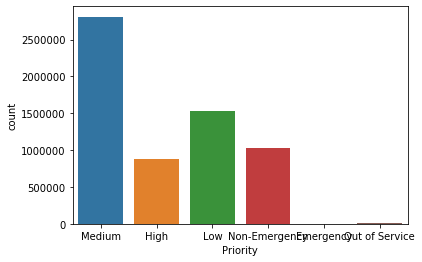

In [40]:
sns.countplot(x='Priority', data=emergency_df)

In [141]:
emergency_df['Priority'].unique()

array(['Medium', 'High', 'Low', 'Non-Emergency', 'Emergency',
       'Out of Service'], dtype=object)

In [234]:
#emergency_df['CallDateTime'].astype('datetime64[ns]')

# Splitting Calls into separate DFs

In [824]:
emergency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406450 entries, 0 to 6406449
Data columns (total 16 columns):
RecordID                       int64
CallNumber                     object
CallDateTime                   object
Priority                       object
District                       object
Description                    object
IncidentLocation               object
ZipCode                        float64
Neighborhood                   object
PoliceDistrict                 object
PolicePost                     float64
CouncilDistrict                float64
SheriffDistricts               object
Community_Statistical_Areas    object
Census_Tracts                  object
Location                       object
dtypes: float64(3), int64(1), object(12)
memory usage: 782.0+ MB


In [4]:
emergency_df['District'].unique()

array(['SD', 'SW', 'SE', 'ND', 'NW', 'ED', 'CD', 'WD', 'NE', 'CW', 'TRU',
       'SS', 'HP', 'EVT1', 'INFO', 'EVT2', 'EVT3', 'FIR1'], dtype=object)

In [5]:
emergency_df.drop(emergency_df[(emergency_df.District == 'TRU') | (emergency_df.District == 'CW')\
                               | (emergency_df.District == 'SS') | (emergency_df.District == 'HP')\
                               | (emergency_df.District == 'EVT1') | (emergency_df.District == 'INFO')\
                               | (emergency_df.District == 'EVT1') | (emergency_df.District == 'EVT2')\
                               | (emergency_df.District == 'EVT3') | (emergency_df.District == 'FIR1')]\
                  .index, inplace=True)

In [6]:
emergency_df.reset_index(drop=True, inplace=True)

In [828]:
emergency_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6245994 entries, 0 to 6245993
Data columns (total 16 columns):
RecordID                       int64
CallNumber                     object
CallDateTime                   object
Priority                       object
District                       object
Description                    object
IncidentLocation               object
ZipCode                        float64
Neighborhood                   object
PoliceDistrict                 object
PolicePost                     float64
CouncilDistrict                float64
SheriffDistricts               object
Community_Statistical_Areas    object
Census_Tracts                  object
Location                       object
dtypes: float64(3), int64(1), object(12)
memory usage: 762.5+ MB


In [7]:
emergency_df['District'].unique()

array(['SD', 'SW', 'SE', 'ND', 'NW', 'ED', 'CD', 'WD', 'NE'], dtype=object)

In [8]:
calls_SD_df = emergency_df[(emergency_df.District == 'SD')]
calls_SD_df.reset_index(drop=True, inplace=True)
calls_SD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694727 entries, 0 to 694726
Data columns (total 16 columns):
RecordID                       694727 non-null int64
CallNumber                     694727 non-null object
CallDateTime                   694727 non-null object
Priority                       694727 non-null object
District                       694727 non-null object
Description                    694727 non-null object
IncidentLocation               694727 non-null object
ZipCode                        694727 non-null float64
Neighborhood                   694727 non-null object
PoliceDistrict                 694727 non-null object
PolicePost                     694727 non-null float64
CouncilDistrict                694727 non-null float64
SheriffDistricts               694727 non-null object
Community_Statistical_Areas    694727 non-null object
Census_Tracts                  694727 non-null object
Location                       694727 non-null object
dtypes: float64(3), int

In [9]:
calls_SW_df = emergency_df[(emergency_df.District == 'SW')]
calls_SW_df.reset_index(drop=True, inplace=True)
calls_SW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715117 entries, 0 to 715116
Data columns (total 16 columns):
RecordID                       715117 non-null int64
CallNumber                     715117 non-null object
CallDateTime                   715117 non-null object
Priority                       715117 non-null object
District                       715117 non-null object
Description                    715117 non-null object
IncidentLocation               715117 non-null object
ZipCode                        715117 non-null float64
Neighborhood                   715117 non-null object
PoliceDistrict                 715117 non-null object
PolicePost                     715117 non-null float64
CouncilDistrict                715117 non-null float64
SheriffDistricts               715117 non-null object
Community_Statistical_Areas    715117 non-null object
Census_Tracts                  715117 non-null object
Location                       715117 non-null object
dtypes: float64(3), int

In [842]:
calls_SE_df = emergency_df[(emergency_df.District == 'SE')]
calls_SE_df.reset_index(drop=True, inplace=True)
calls_SE_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689590 entries, 0 to 689589
Data columns (total 16 columns):
RecordID                       689590 non-null int64
CallNumber                     689590 non-null object
CallDateTime                   689590 non-null object
Priority                       689590 non-null object
District                       689590 non-null object
Description                    689590 non-null object
IncidentLocation               689590 non-null object
ZipCode                        689590 non-null float64
Neighborhood                   689590 non-null object
PoliceDistrict                 689590 non-null object
PolicePost                     689590 non-null float64
CouncilDistrict                689590 non-null float64
SheriffDistricts               689590 non-null object
Community_Statistical_Areas    689590 non-null object
Census_Tracts                  689590 non-null object
Location                       689590 non-null object
dtypes: float64(3), int

In [843]:
calls_ND_df = emergency_df[(emergency_df.District == 'ND')]
calls_ND_df.reset_index(drop=True, inplace=True)
calls_ND_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653535 entries, 0 to 653534
Data columns (total 16 columns):
RecordID                       653535 non-null int64
CallNumber                     653535 non-null object
CallDateTime                   653535 non-null object
Priority                       653535 non-null object
District                       653535 non-null object
Description                    653535 non-null object
IncidentLocation               653535 non-null object
ZipCode                        653535 non-null float64
Neighborhood                   653535 non-null object
PoliceDistrict                 653535 non-null object
PolicePost                     653535 non-null float64
CouncilDistrict                653535 non-null float64
SheriffDistricts               653535 non-null object
Community_Statistical_Areas    653535 non-null object
Census_Tracts                  653535 non-null object
Location                       653535 non-null object
dtypes: float64(3), int

In [844]:
calls_NW_df = emergency_df[(emergency_df.District == 'NW')]
calls_NW_df.reset_index(drop=True, inplace=True)
calls_NW_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639622 entries, 0 to 639621
Data columns (total 16 columns):
RecordID                       639622 non-null int64
CallNumber                     639622 non-null object
CallDateTime                   639622 non-null object
Priority                       639622 non-null object
District                       639622 non-null object
Description                    639622 non-null object
IncidentLocation               639622 non-null object
ZipCode                        639622 non-null float64
Neighborhood                   639622 non-null object
PoliceDistrict                 639622 non-null object
PolicePost                     639622 non-null float64
CouncilDistrict                639622 non-null float64
SheriffDistricts               639622 non-null object
Community_Statistical_Areas    639622 non-null object
Census_Tracts                  639622 non-null object
Location                       639622 non-null object
dtypes: float64(3), int

In [845]:
calls_ED_df = emergency_df[(emergency_df.District == 'ED')]
calls_ED_df.reset_index(drop=True, inplace=True)
calls_ED_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598424 entries, 0 to 598423
Data columns (total 16 columns):
RecordID                       598424 non-null int64
CallNumber                     598424 non-null object
CallDateTime                   598424 non-null object
Priority                       598424 non-null object
District                       598424 non-null object
Description                    598424 non-null object
IncidentLocation               598424 non-null object
ZipCode                        598424 non-null float64
Neighborhood                   598424 non-null object
PoliceDistrict                 598424 non-null object
PolicePost                     598424 non-null float64
CouncilDistrict                598424 non-null float64
SheriffDistricts               598424 non-null object
Community_Statistical_Areas    598424 non-null object
Census_Tracts                  598424 non-null object
Location                       598424 non-null object
dtypes: float64(3), int

In [846]:
calls_CD_df = emergency_df[(emergency_df.District == 'CD')]
calls_CD_df.reset_index(drop=True, inplace=True)
calls_CD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694923 entries, 0 to 694922
Data columns (total 16 columns):
RecordID                       694923 non-null int64
CallNumber                     694923 non-null object
CallDateTime                   694923 non-null object
Priority                       694923 non-null object
District                       694923 non-null object
Description                    694923 non-null object
IncidentLocation               694923 non-null object
ZipCode                        694923 non-null float64
Neighborhood                   694923 non-null object
PoliceDistrict                 694923 non-null object
PolicePost                     694923 non-null float64
CouncilDistrict                694923 non-null float64
SheriffDistricts               694923 non-null object
Community_Statistical_Areas    694923 non-null object
Census_Tracts                  694923 non-null object
Location                       694923 non-null object
dtypes: float64(3), int

In [847]:
calls_WD_df = emergency_df[(emergency_df.District == 'WD')]
calls_WD_df.reset_index(drop=True, inplace=True)
calls_WD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654725 entries, 0 to 654724
Data columns (total 16 columns):
RecordID                       654725 non-null int64
CallNumber                     654725 non-null object
CallDateTime                   654725 non-null object
Priority                       654725 non-null object
District                       654725 non-null object
Description                    654725 non-null object
IncidentLocation               654725 non-null object
ZipCode                        654725 non-null float64
Neighborhood                   654725 non-null object
PoliceDistrict                 654725 non-null object
PolicePost                     654725 non-null float64
CouncilDistrict                654725 non-null float64
SheriffDistricts               654725 non-null object
Community_Statistical_Areas    654725 non-null object
Census_Tracts                  654725 non-null object
Location                       654725 non-null object
dtypes: float64(3), int

In [848]:
calls_NE_df = emergency_df[(emergency_df.District == 'NE')]
calls_NE_df.reset_index(drop=True, inplace=True)
calls_NE_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905331 entries, 0 to 905330
Data columns (total 16 columns):
RecordID                       905331 non-null int64
CallNumber                     905331 non-null object
CallDateTime                   905331 non-null object
Priority                       905331 non-null object
District                       905331 non-null object
Description                    905331 non-null object
IncidentLocation               905331 non-null object
ZipCode                        905331 non-null float64
Neighborhood                   905331 non-null object
PoliceDistrict                 905331 non-null object
PolicePost                     905331 non-null float64
CouncilDistrict                905331 non-null float64
SheriffDistricts               905331 non-null object
Community_Statistical_Areas    905331 non-null object
Census_Tracts                  905331 non-null object
Location                       905331 non-null object
dtypes: float64(3), int

In [11]:
blah = calls_SD_df.merge(calls_SW_df, 'outer')
blah.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409844 entries, 0 to 1409843
Data columns (total 16 columns):
RecordID                       1409844 non-null int64
CallNumber                     1409844 non-null object
CallDateTime                   1409844 non-null object
Priority                       1409844 non-null object
District                       1409844 non-null object
Description                    1409844 non-null object
IncidentLocation               1409844 non-null object
ZipCode                        1409844 non-null float64
Neighborhood                   1409844 non-null object
PoliceDistrict                 1409844 non-null object
PolicePost                     1409844 non-null float64
CouncilDistrict                1409844 non-null float64
SheriffDistricts               1409844 non-null object
Community_Statistical_Areas    1409844 non-null object
Census_Tracts                  1409844 non-null object
Location                       1409844 non-null object
dtype

## Plotting Calls

In [18]:
def agg_df(df, mdy):
    new_df = pd.DataFrame()
    new_df['CallDateTime'] = df.loc[df["CallDateTime"].notnull(), "CallDateTime"].copy(deep=True)

    # #convert to time series
    new_df["CallDateTime"] = new_df["CallDateTime"].apply(pd.to_datetime)
    new_df = new_df.set_index(new_df["CallDateTime"])

    # # Group by month = M, by week = W, by day = D
    grouped = new_df.resample(mdy).count()
    new_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
    return (new_df)

In [852]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [ ]:
calls_m_SD_df = agg_df(calls_SD_df, "M")
calls_w_SD_df = agg_df(calls_SD_df, "W")
calls_d_SD_df = agg_df(calls_SD_df, "D")

In [27]:
calls_m_SD_df = agg_df(calls_SD_df, "M")

In [36]:
calls_m_SD_df.loc['2013-07-31', 'count']

10527

In [631]:
time_series_w_df = pd.DataFrame()
time_series_w_df['CallDateTime'] = emergency_df.loc[emergency_df["CallDateTime"].notnull(), "CallDateTime"].copy(deep=True)

# #convert to time series
time_series_w_df["CallDateTime"] = time_series_w_df["CallDateTime"].apply(pd.to_datetime)
time_series_w_df = time_series_w_df.set_index(time_series_w_df["CallDateTime"])

# # Group by month = M, by week = W, by day = D
grouped = time_series_w_df.resample("W").count()
time_series_w_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
time_series_df.head()

,count
CallDateTime,
2013-06-30,6
2013-07-07,23119
2013-07-14,21771
2013-07-21,21751
2013-07-28,22486


In [42]:
time_series_d_df = pd.DataFrame()
time_series_d_df['CallDateTime'] = emergency_df.loc[emergency_df["CallDateTime"].notnull(), "CallDateTime"].copy(deep=True)

# #convert to time series
time_series_d_df["CallDateTime"] = time_series_d_df["CallDateTime"].apply(pd.to_datetime)
time_series_d_df = time_series_d_df.set_index(time_series_d_df["CallDateTime"])

# # Group by month = M, by week = W, by day = D
grouped = time_series_d_df.resample("D").count()
time_series_d_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
time_series_d_df.head()

,count
CallDateTime,
2013-06-30,6
2013-07-01,3290
2013-07-02,3236
2013-07-03,3525
2013-07-04,3511


In [641]:
time_series_m_df = pd.DataFrame()
time_series_m_df['CallDateTime'] = emergency_df.loc[emergency_df["CallDateTime"].notnull(), "CallDateTime"].copy(deep=True)

# #convert to time series
time_series_m_df["CallDateTime"] = time_series_m_df["CallDateTime"].apply(pd.to_datetime)
time_series_m_df = time_series_m_df.set_index(time_series_m_df["CallDateTime"])

# # Group by month = M, by week = W, by day = D
grouped = time_series_m_df.resample("M").count()
time_series_m_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
time_series_m_df.head()

,count
CallDateTime,
2013-06-30,6
2013-07-31,98261
2013-08-31,99403
2013-09-30,92417
2013-10-31,93051


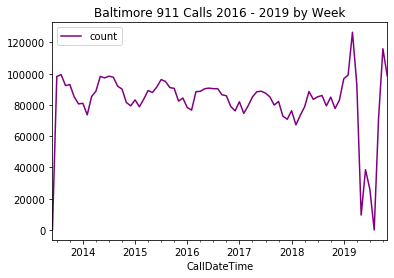

In [440]:
def is_between_2013_and_now(date):
    return date <= datetime.datetime(2019, 12, 31)

time_series_df = time_series_df[time_series_df.index.to_series().apply(is_between_2013_and_now)]
time_series_df.plot(color="purple", title='Baltimore 911 Calls 2016 - 2019 by Week')
#time_series_w_df.plot(color="purple", title='Baltimore 911 Calls 2016 - 2019 by Week')

In [326]:
#time_series_df = time_series_w_df

In [327]:
#spring slopes upward
#summer spikes
#winter dips
#large spike in march 2019! then large dip after that


#time_series_df = emergency_df.iloc[:,9:]
#time_series_df = time_series_df[]
time_series_df.head()

,count
CallDateTime,
2013-06-30,6
2013-07-01,3294
2013-07-02,3243
2013-07-03,3539
2013-07-04,3521


In [107]:
# month_year_df = time_series_df.groupby(['year', 'month']).size().reset_index(name='counts')

# month_year_df.head()

,year,month,counts
0,2015,1,83994
1,2015,2,79637
2,2015,3,86243
3,2015,4,88179
4,2015,5,85339


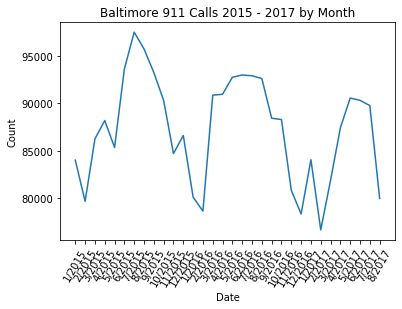

In [118]:
# plt.plot(month_year_df['month'].astype(str) +'/'+ month_year_df['year'].astype(str), month_year_df['counts'])
# plt.title('Baltimore 911 Calls 2015 - 2017 by Month')
# plt.xlabel('Date')
# plt.xticks(rotation=60)
# plt.ylabel('Count');
# plt.show()
#summer spikes
#winter dips

In [818]:
emergency_df.head()

,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,Location
0,2333660,P163072128,11/02/2016 04:46:00 PM,Medium,SD,NARCOTICSOutside,1200 W CROSS ST,21230.0,Washington Village/Pigtown,Southern,932.0,10.0,D7,Washington Village/Pigtown,Census Tract 2102,"1200 W CROSS ST\nBALTIMORE, MD\n(39.281995, -7..."
1,2334887,P163070732,11/02/2016 09:22:00 AM,High,SW,Traffic Stop,2100 W PRATT ST,21223.0,Carrollton Ridge,Southwestern,841.0,9.0,D8,Southwest Baltimore,Census Tract 2005,"2100 W PRATT ST\nBALTIMORE, MD\n(39.284965, -7..."
2,2334245,P163071480,11/02/2016 01:37:00 PM,Low,SE,LARCENY F/AUTO,HOME DEPOT,21224.0,Pulaski Industrial Area,Southeastern,242.0,1.0,D6,Orangeville/East Highlandtown,Census Tract 2605.01,"HOME DEPOT BALTIMORE, MD\n(39.499699, -76.641403)"
3,2332907,P163072974,11/02/2016 08:20:00 PM,Medium,ND,911/NO VOICE,5200 YORK RD,21212.0,York-Homeland,Northern,521.0,4.0,D2,North Baltimore/Guilford/Homeland,Census Tract 2711.01,"5200 YORK RD\nBALTIMORE, MD\n(39.352315, -76.6..."
4,2332699,P163073203,11/02/2016 09:39:00 PM,Medium,NW,COMMON ASSAULT,2500 N ELLAMONT ST,21216.0,Hanlon-Longwood,Northwestern,641.0,7.0,D9,Greater Mondawmin,Census Tract 1507.01,"2500 N ELLAMONT ST\nBALTIMORE, MD\n(39.315441,..."


,RecordID,CallNumber,CallDateTime,Priority,District,Description,IncidentLocation,ZipCode,Neighborhood,PoliceDistrict,PolicePost,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,Location


## Plotting Arrests

In [330]:
arrests_df = pd.read_pickle('./arrests_df')
arrests_df.head()

,Arrest,Age,Sex,Race,ArrestDate,ArrestTime,ArrestLocation,IncidentOffense,IncidentLocation,Charge,ChargeDescription,District,Post,Longitude,Latitude
0,NaN,29.0,M,B,02/28/2019,9:20,NaN,Unknown Offense,NaN,NaN,Unknown Charge,NaN,NaN,NaN,NaN
1,19029683.0,36.0,M,B,02/27/2019,12:10,200 EDEN ST,Unknown Offense,200 EDEN ST,1 1111,CDS PWID,Southeast,212,-76.598568971120,39.2888
2,19094289.0,45.0,F,B,06/28/2019,10:43,NaN,Unknown Offense,NaN,1 1420,ASSAULT-FIRST DEGREE,NaN,NaN,NaN,NaN
3,19093811.0,39.0,M,B,06/27/2019,11:34,NaN,Unknown Offense,NaN,NaN,TEMP FED DETAINEE,NaN,NaN,NaN,NaN
4,19028506.0,45.0,M,B,02/25/2019,13:35,NaN,Unknown Offense,NaN,1 0077,FAILURE TO APPEAR,NaN,NaN,NaN,NaN


In [382]:
arrests_date_df = arrests_df[arrests_df["ArrestDate"].notnull()]
arrests_date_df = arrests_date_df[["ArrestDate"]].reset_index(drop=True)
arrests_date_df.head()

,ArrestDate
0,02/28/2019
1,02/27/2019
2,06/28/2019
3,06/27/2019
4,02/25/2019


In [383]:
arrests_date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151469 entries, 0 to 151468
Data columns (total 1 columns):
ArrestDate    151469 non-null object
dtypes: object(1)
memory usage: 1.2+ MB


In [185]:
# arrests_date_df['ArrestDate'] = arrests_date_df['ArrestDate'].astype('datetime64[ns]')
# arrests_date_df

# arrests_date_df['day'] = arrests_date_df['ArrestDate'].dt.day

# arrests_date_df['month'] = arrests_date_df['ArrestDate'].dt.month

# arrests_date_df['year'] = arrests_date_df['ArrestDate'].dt.year

# arrests_date_df.head()

# arrests_date_df = arrests_date_df[arrests_date_df['year']>=2016]
# arrests_date_df.head()

# arrests_date_df = arrests_date_df.groupby(['year', 'month']).size().reset_index(name='counts')
# arrests_date_df.head()

# plt.plot(arrests_date_df['month'].astype(str) +'/'+ arrests_date_df['year'].astype(str), arrests_date_df['counts'])
# plt.title('Baltimore Arrests by Month 2016 - 2019')
# plt.xlabel('Date')
# plt.xticks(rotation=60)
# plt.ylabel('Count');
# plt.show()

,ArrestDate
0,2019-02-28
1,2019-02-27
2,2019-06-28
3,2019-06-27
4,2019-02-25
...,...
151464,2014-01-01
151465,2014-01-01
151466,2014-01-01
151467,2014-01-01


In [442]:
arrests_date_df = pd.DataFrame()
arrests_date_df['ArrestDate'] = arrests_df.loc[arrests_df['ArrestDate'].notnull(), "ArrestDate"].copy(deep=True)

# #convert to time series
arrests_date_df['ArrestDate'] = arrests_date_df['ArrestDate'].apply(pd.to_datetime)
arrests_date_df = arrests_date_df.set_index(arrests_date_df['ArrestDate'])

# # Group by month = M, by week = W, by day = D
grouped = arrests_date_df.resample("M").count()
arrests_date_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
arrests_date_df.head()

,count
ArrestDate,
2014-01-31,3319
2014-02-28,3014
2014-03-31,3477
2014-04-30,3600
2014-05-31,3711


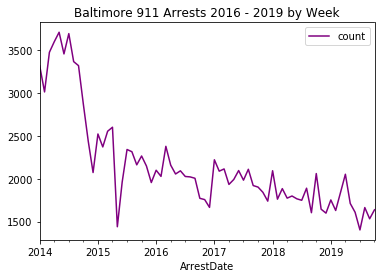

In [443]:
arrests_date_df = arrests_date_df[arrests_date_df.index.to_series().apply(is_between_2013_and_now)]
arrests_date_df.plot(color="purple", title='Baltimore 911 Arrests 2016 - 2019 by Week')

In [693]:
arrests_date_m_df = pd.DataFrame()
arrests_date_m_df['ArrestDate'] = arrests_df.loc[arrests_df['ArrestDate'].notnull(), "ArrestDate"].copy(deep=True)

# #convert to time series
arrests_date_m_df['ArrestDate'] = arrests_date_m_df['ArrestDate'].apply(pd.to_datetime)
arrests_date_m_df = arrests_date_m_df.set_index(arrests_date_m_df['ArrestDate'])

# # Group by month = M, by week = W, by day = D
grouped = arrests_date_m_df.resample("M").count()
arrests_date_m_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
arrests_date_m_df.head()

,count
ArrestDate,
2014-01-31,3319
2014-02-28,3014
2014-03-31,3477
2014-04-30,3600
2014-05-31,3711


In [694]:
arrests_date_w_df = pd.DataFrame()
arrests_date_w_df['ArrestDate'] = arrests_df.loc[arrests_df['ArrestDate'].notnull(), "ArrestDate"].copy(deep=True)

# #convert to time series
arrests_date_w_df['ArrestDate'] = arrests_date_w_df['ArrestDate'].apply(pd.to_datetime)
arrests_date_w_df = arrests_date_w_df.set_index(arrests_date_w_df['ArrestDate'])

# # Group by month = M, by week = W, by day = D
grouped = arrests_date_w_df.resample("W").count()
arrests_date_w_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
arrests_date_w_df.head()

,count
ArrestDate,
2014-01-05,433
2014-01-12,803
2014-01-19,843
2014-01-26,643
2014-02-02,789


In [695]:
arrests_date_d_df = pd.DataFrame()
arrests_date_d_df['ArrestDate'] = arrests_df.loc[arrests_df['ArrestDate'].notnull(), "ArrestDate"].copy(deep=True)

# #convert to time series
arrests_date_d_df['ArrestDate'] = arrests_date_d_df['ArrestDate'].apply(pd.to_datetime)
arrests_date_d_df = arrests_date_d_df.set_index(arrests_date_d_df['ArrestDate'])

# # Group by month = M, by week = W, by day = D
grouped = arrests_date_d_df.resample("D").count()
arrests_date_d_df = pd.DataFrame({"count": grouped.values.flatten()}, index=grouped.index)
arrests_date_d_df.head()

,count
ArrestDate,
2014-01-01,107
2014-01-02,107
2014-01-03,77
2014-01-04,86
2014-01-05,56


## Time Series Decomposition for 911 Calls and Arrests

## Monthly Calls

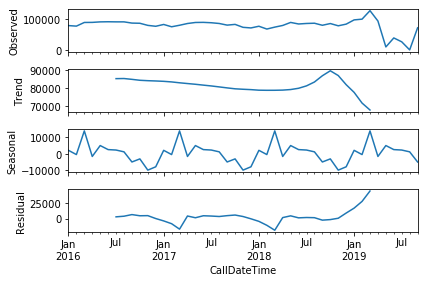

In [179]:
# result_calls = seasonal_decompose(time_series_df)
# fig_calls = result_calls.plot()


#most calls in march

## Monthly Arrests

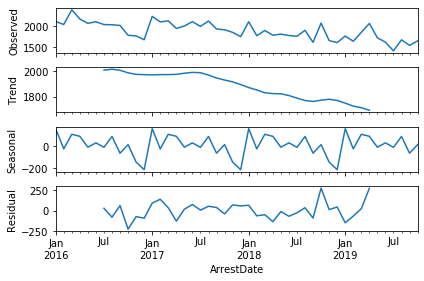

In [192]:
#most arrests in December leading to Jan(jan has the most), march is the second most
#maybe December arrests are of theft type since holidays, but march arrests are for violence or personal? which is why there are more calls???

# result_arrests = seasonal_decompose(arrests_date_df)
# fig_arrests = result_arrests.plot()

In [193]:
#arrests_date_df.head()

,count
ArrestDate,
2016-01-31,2100
2016-02-29,2028
2016-03-31,2379
2016-04-30,2159
2016-05-31,2056


## Weekly Calls

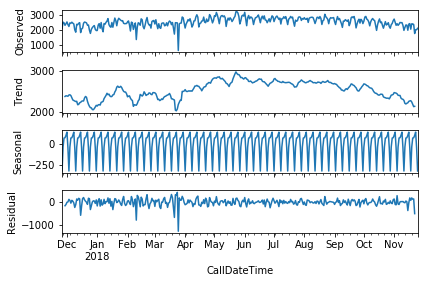

In [169]:
result_calls = seasonal_decompose(time_series_d_df[-730:-365])
fig_calls = result_calls.plot()

## Weekly Arrests

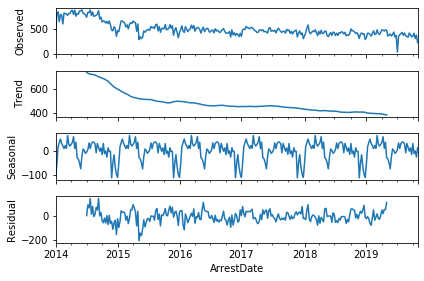

In [386]:
# result_arrests = seasonal_decompose(arrests_date_df)
# fig_arrests = result_arrests.plot()

## Daily Calls

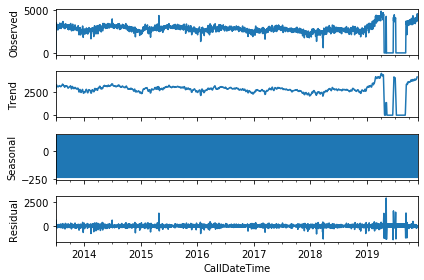

In [334]:
# result_calls = seasonal_decompose(time_series_df)
# fig_calls = result_calls.plot()

## Daily Arrests

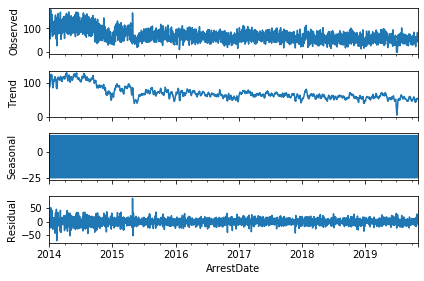

In [335]:
# result_arrests = seasonal_decompose(arrests_date_df)
# fig_arrests = result_arrests.plot()

## FB Prophet Predictions for Calls and Arrests

In [44]:
def get_test_2019_data(date):
    return date >= datetime.datetime(2018, 1, 1) and date <= datetime.datetime(2018, 12, 31)

def get_train_data(date):
    return date <= datetime.datetime(2017, 12, 31)


In [445]:
#log+1 transform the counts
time_series_df['log_count'] = np.log(time_series_df['count']+1)
#time_series_df.iloc[0,1]

In [446]:
arrests_date_df['log_count'] = np.log(arrests_date_df['count']+1)
arrests_date_df

,count,log_count
ArrestDate,,
2014-01-31,3319,8.107720
2014-02-28,3014,8.011355
2014-03-31,3477,8.154213
2014-04-30,3600,8.188967
2014-05-31,3711,8.219326
...,...,...
2019-06-30,1609,7.383989
2019-07-31,1403,7.247081
2019-08-31,1664,7.417580


### Initialize prophet models and split into train and test

In [46]:
def get_test_train_split(df):
    train = df[df.index.to_series().apply(get_train_data)]
    train = train.rename(columns={"count":'y'})
    train["ds"] = train.index

    test = df[df.index.to_series().apply(get_test_2019_data)]
    test = test.rename(columns={"count":'y'})
    test["ds"] = test.index
    return(train, test)

In [633]:
model_calls = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)
model_arrests = Prophet(yearly_seasonality=True, daily_seasonality=True, weekly_seasonality=True)

train_calls_df = time_series_df[time_series_df.index.to_series().apply(get_train_data)]
train_calls_df = train_calls_df.rename(columns={"count":'y'})
train_calls_df["ds"] = train_calls_df.index

test_calls_df = time_series_df[time_series_df.index.to_series().apply(get_test_2019_data)]
test_calls_df = test_calls_df.rename(columns={"count":'y'})
test_calls_df["ds"] = test_calls_df.index

train_arrests_df = arrests_date_df[arrests_date_df.index.to_series().apply(get_train_data)]
train_arrests_df = train_arrests_df.rename(columns={"count":'y'})
train_arrests_df["ds"] = train_arrests_df.index

test_arrests_df = arrests_date_df[arrests_date_df.index.to_series().apply(get_test_2019_data)]
test_arrests_df = test_arrests_df.rename(columns={"count":'y'})
test_arrests_df["ds"] = test_arrests_df.index

model_calls.fit(train_calls_df)
model_arrests.fit(train_arrests_df)

In [663]:
train_calls_m_df = time_series_m_df[time_series_m_df.index.to_series().apply(get_train_data)]
train_calls_m_df = train_calls_m_df.rename(columns={"count":'y'})
train_calls_m_df["ds"] = train_calls_m_df.index

test_calls_m_df = time_series_m_df[time_series_m_df.index.to_series().apply(get_test_2019_data)]
test_calls_m_df = test_calls_m_df.rename(columns={"count":'y'})
test_calls_m_df["ds"] = test_calls_m_df.index



In [664]:
train_calls_w_df = time_series_w_df[time_series_w_df.index.to_series().apply(get_train_data)]
train_calls_w_df = train_calls_w_df.rename(columns={"count":'y'})
train_calls_w_df["ds"] = train_calls_w_df.index

test_calls_w_df = time_series_w_df[time_series_w_df.index.to_series().apply(get_test_2019_data)]
test_calls_w_df = test_calls_w_df.rename(columns={"count":'y'})
test_calls_w_df["ds"] = test_calls_w_df.index



In [47]:
train_calls_d_df = time_series_d_df[time_series_d_df.index.to_series().apply(get_train_data)]
train_calls_d_df = train_calls_d_df.rename(columns={"count":'y'})
train_calls_d_df["ds"] = train_calls_d_df.index

test_calls_d_df = time_series_d_df[time_series_d_df.index.to_series().apply(get_test_2019_data)]
test_calls_d_df = test_calls_d_df.rename(columns={"count":'y'})
test_calls_d_df["ds"] = test_calls_d_df.index



In [696]:
train_arrests_m_df = arrests_date_m_df[arrests_date_m_df.index.to_series().apply(get_train_data)]
train_arrests_m_df = train_arrests_m_df.rename(columns={"count":'y'})
train_arrests_m_df["ds"] = train_arrests_m_df.index

test_arrests_m_df = arrests_date_m_df[arrests_date_m_df.index.to_series().apply(get_test_2019_data)]
test_arrests_m_df = test_arrests_m_df.rename(columns={"count":'y'})
test_arrests_m_df["ds"] = test_arrests_m_df.index



In [697]:
train_arrests_w_df = arrests_date_w_df[arrests_date_w_df.index.to_series().apply(get_train_data)]
train_arrests_w_df = train_arrests_w_df.rename(columns={"count":'y'})
train_arrests_w_df["ds"] = train_arrests_w_df.index

test_arrests_w_df = arrests_date_w_df[arrests_date_w_df.index.to_series().apply(get_test_2019_data)]
test_arrests_w_df = test_arrests_w_df.rename(columns={"count":'y'})
test_arrests_w_df["ds"] = test_arrests_w_df.index

In [698]:
train_arrests_d_df = arrests_date_d_df[arrests_date_d_df.index.to_series().apply(get_train_data)]
train_arrests_d_df = train_arrests_d_df.rename(columns={"count":'y'})
train_arrests_d_df["ds"] = train_arrests_d_df.index

test_arrests_d_df = arrests_date_d_df[arrests_date_d_df.index.to_series().apply(get_test_2019_data)]
test_arrests_d_df = test_arrests_d_df.rename(columns={"count":'y'})
test_arrests_d_df["ds"] = test_arrests_d_df.index

In [ ]:
# by district test code

In [854]:
train_m_SD, test_m_SD = get_test_train_split(calls_m_SD_df)
train_w_SD, test_w_SD = get_test_train_split(calls_w_SD_df)
train_d_SD, test_d_SD = get_test_train_split(calls_d_SD_df)

### Prediciting Future Call Counts by Month

##### Baseline Model Predictions

In [475]:
baseline_calls_train_df = train_calls_df

baseline_calls_train_y_avg,baseline_calls_train_log_y_avg = baseline_calls_train_df.mean(axis=0)#['y'].mean()


11.192286788613771

12

###### Metrics and Plotting Baseline

In [484]:
print(f'r2: {r2_score(test_calls_df.y, [baseline_calls_train_y_avg] * test_calls_df.y.size)}')
print(f'MSE: {mean_squared_error(test_calls_df.y, [baseline_calls_train_y_avg] * test_calls_df.y.size)}')
print(f'MAE: {mean_absolute_error(test_calls_df.y, [baseline_calls_train_y_avg] * test_calls_df.y.size)}')

#model_calls.plot(future_calls_df)

r2: -0.5842851320433353
MSE: 54077557.72760337
MAE: 5382.839393939396


In [458]:
future_calls_df = model_calls.predict(test_calls_df)
future_calls_df.head(10)
future_calls_df.join(test_calls_df['y']).reset_index()
future_calls_df = future_calls_df.set_index('ds').join(test_calls_df.set_index('ds').y).reset_index()
future_calls_df.dropna(inplace=True)
future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-31,76302,79129.473945,65935.682874,92471.615932
1,2018-02-28,67246,70802.376895,57663.205985,83601.277146
2,2018-03-31,73455,78032.153426,63807.631200,90313.588634
3,2018-04-30,78825,91265.225851,77892.477230,104629.423116
4,2018-05-31,88594,99844.182873,86071.136878,112628.448495


In [459]:
future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 5 columns):
ds            12 non-null datetime64[ns]
y             12 non-null int64
yhat          12 non-null float64
yhat_lower    12 non-null float64
yhat_upper    12 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 576.0 bytes


#### Metrics and Plotting Future Call Counts Predictions by Month

r2: -0.8533491413785628
MSE: 63261715.42936748
MAE: 6998.196284349401


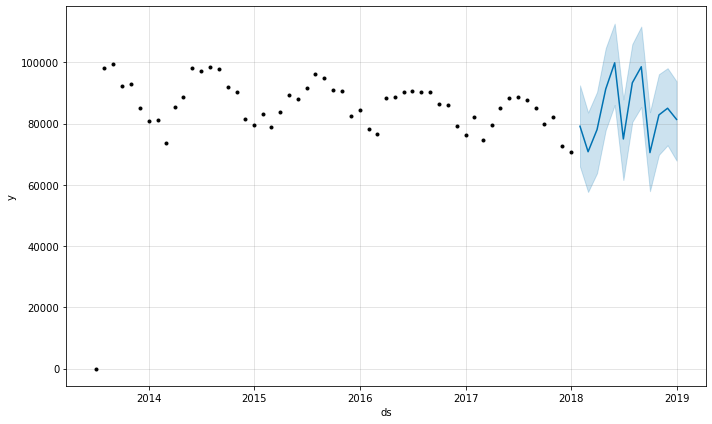

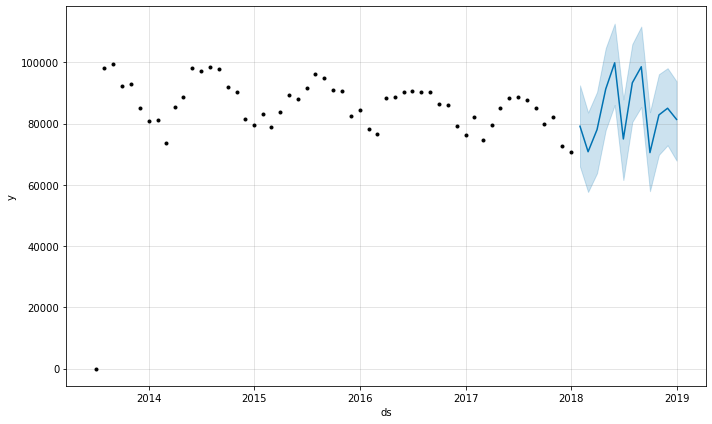

In [460]:
print(f'r2: {r2_score(future_calls_df.y, future_calls_df.yhat)}')
print(f'MSE: {mean_squared_error(future_calls_df.y, future_calls_df.yhat)}')
print(f'MAE: {mean_absolute_error(future_calls_df.y, future_calls_df.yhat)}')

model_calls.plot(future_calls_df)

### Predicting Future Arrest Counts by Month

In [601]:
future_arrests_df = model_arrests.predict(test_arrests_df)
future_arrests_df.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-31,-1491.441340,1466.689549,1951.404809,-1492.389376,-1490.431108,3206.311936,3206.311936,3206.311936,3351.310685,...,-111.793896,-111.793896,-111.793896,-33.204853,-33.204853,-33.204853,0.0,0.0,0.0,1714.870596
1,2018-02-28,-1500.627452,1300.175466,1772.380678,-1504.072630,-1496.951362,3034.169143,3034.169143,3034.169143,3351.310685,...,-111.793896,-111.793896,-111.793896,-205.347646,-205.347646,-205.347646,0.0,0.0,0.0,1533.541691
2,2018-03-31,-1510.797792,1864.915119,2335.574365,-1518.318010,-1502.454982,3599.535980,3599.535980,3599.535980,3351.310685,...,123.239481,123.239481,123.239481,124.985814,124.985814,124.985814,0.0,0.0,0.0,2088.738189
3,2018-04-30,-1520.640055,1853.159268,2327.573415,-1532.989213,-1506.910674,3611.931382,3611.931382,3611.931382,3351.310685,...,31.117123,31.117123,31.117123,229.503574,229.503574,229.503574,0.0,0.0,0.0,2091.291327
4,2018-05-31,-1530.810395,1490.415158,1944.196223,-1549.395304,-1509.903675,3242.336724,3242.336724,3242.336724,3351.310685,...,50.542524,50.542524,50.542524,-159.516485,-159.516485,-159.516485,0.0,0.0,0.0,1711.526330
5,2018-06-30,-1540.652658,1677.836670,2159.994967,-1566.139709,-1513.407627,3467.426738,3467.426738,3467.426738,3351.310685,...,123.239481,123.239481,123.239481,-7.123429,-7.123429,-7.123429,0.0,0.0,0.0,1926.774079
6,2018-07-31,-1550.822997,1931.988642,2417.869819,-1583.705809,-1516.211424,3719.299751,3719.299751,3719.299751,3351.310685,...,86.208476,86.208476,86.208476,281.780590,281.780590,281.780590,0.0,0.0,0.0,2168.476753
7,2018-08-31,-1560.993337,1649.648250,2123.151174,-1600.564431,-1518.052731,3461.178988,3461.178988,3461.178988,3351.310685,...,-93.504653,-93.504653,-93.504653,203.372955,203.372955,203.372955,0.0,0.0,0.0,1900.185651
8,2018-09-30,-1570.835600,1536.212325,2021.803516,-1617.477392,-1519.861522,3362.206252,3362.206252,3362.206252,3351.310685,...,-85.809055,-85.809055,-85.809055,96.704622,96.704622,96.704622,0.0,0.0,0.0,1791.370652
9,2018-10-31,-1581.005939,1377.620037,1858.028262,-1636.185264,-1519.289397,3199.320343,3199.320343,3199.320343,3351.310685,...,-111.793896,-111.793896,-111.793896,-40.196446,-40.196446,-40.196446,0.0,0.0,0.0,1618.314404


In [602]:
#future_arrest_df.join(test_arrests_df['y']).reset_index()
future_arrests_df = future_arrests_df.set_index('ds').join(test_arrests_df.set_index('ds').y).reset_index()
future_arrests_df.dropna(inplace=True)
future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-31,2094,1714.870596,1466.689549,1951.404809
1,2018-02-28,1762,1533.541691,1300.175466,1772.380678
2,2018-03-31,1885,2088.738189,1864.915119,2335.574365
3,2018-04-30,1774,2091.291327,1853.159268,2327.573415
4,2018-05-31,1799,1711.526330,1490.415158,1944.196223


In [463]:
future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 5 columns):
ds            12 non-null datetime64[ns]
y             12 non-null int64
yhat          12 non-null float64
yhat_lower    12 non-null float64
yhat_upper    12 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 576.0 bytes


#### Metrics and Plotting Arrests Predictions by Month

r2: -1.8925507543953146
MSE: 67140.12044111859
MAE: 222.38042167371577


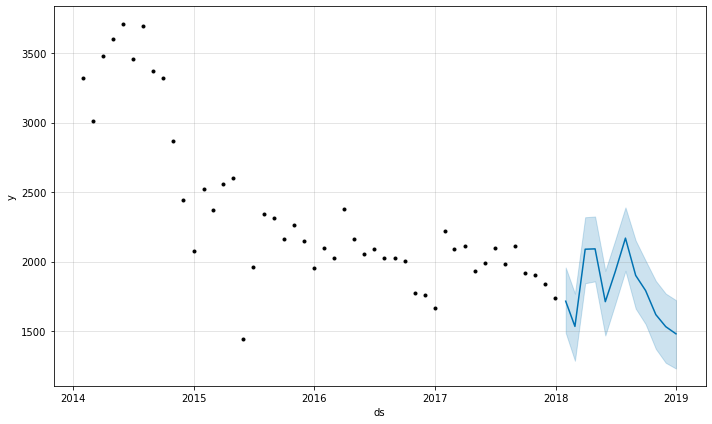

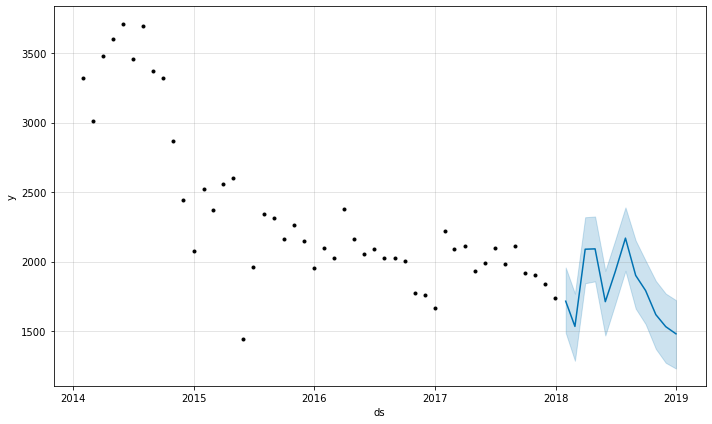

In [464]:
print(f'r2: {r2_score(future_arrests_df.y, future_arrests_df.yhat)}')
print(f'MSE: {mean_squared_error(future_arrests_df.y, future_arrests_df.yhat)}')
print(f'MAE: {mean_absolute_error(future_arrests_df.y, future_arrests_df.yhat)}')

model_arrests.plot(future_arrests_df)

### Prediciting Future Call Counts by Week

In [413]:
# future_calls_df = model_calls.predict(test_calls_df)
# future_calls_df.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-07,3.143512,9.071060,10.315398,3.143512,3.143512,6.580386,6.580386,6.580386,3.819853,...,2.86489,2.86489,2.86489,-0.104357,-0.104357,-0.104357,0.0,0.0,0.0,9.723898
1,2018-01-14,3.142887,9.071190,10.378333,3.142887,3.142887,6.636912,6.636912,6.636912,3.819853,...,2.86489,2.86489,2.86489,-0.047832,-0.047832,-0.047832,0.0,0.0,0.0,9.779799
2,2018-01-21,3.142263,9.196382,10.439874,3.142064,3.142524,6.652392,6.652392,6.652392,3.819853,...,2.86489,2.86489,2.86489,-0.032351,-0.032351,-0.032351,0.0,0.0,0.0,9.794656
3,2018-01-28,3.141639,9.161968,10.385794,3.141038,3.142414,6.630620,6.630620,6.630620,3.819853,...,2.86489,2.86489,2.86489,-0.054124,-0.054124,-0.054124,0.0,0.0,0.0,9.772259
4,2018-02-04,3.141015,9.119299,10.384749,3.139870,3.142514,6.620987,6.620987,6.620987,3.819853,...,2.86489,2.86489,2.86489,-0.063756,-0.063756,-0.063756,0.0,0.0,0.0,9.762001
5,2018-02-11,3.140390,9.143825,10.430592,3.138561,3.142675,6.644416,6.644416,6.644416,3.819853,...,2.86489,2.86489,2.86489,-0.040327,-0.040327,-0.040327,0.0,0.0,0.0,9.784806
6,2018-02-18,3.139766,9.186978,10.450809,3.137373,3.142933,6.664536,6.664536,6.664536,3.819853,...,2.86489,2.86489,2.86489,-0.020207,-0.020207,-0.020207,0.0,0.0,0.0,9.804302
7,2018-02-25,3.139142,9.187172,10.418840,3.136049,3.143131,6.643564,6.643564,6.643564,3.819853,...,2.86489,2.86489,2.86489,-0.041179,-0.041179,-0.041179,0.0,0.0,0.0,9.782706
8,2018-03-04,3.138517,9.115206,10.364740,3.134634,3.143356,6.603174,6.603174,6.603174,3.819853,...,2.86489,2.86489,2.86489,-0.081570,-0.081570,-0.081570,0.0,0.0,0.0,9.741691
9,2018-03-11,3.137893,9.111755,10.364180,3.132887,3.143897,6.601435,6.601435,6.601435,3.819853,...,2.86489,2.86489,2.86489,-0.083308,-0.083308,-0.083308,0.0,0.0,0.0,9.739328


In [414]:
# future_calls_df.join(test_calls_df['y']).reset_index()
# future_calls_df = future_calls_df.set_index('ds').join(test_calls_df.set_index('ds').y).reset_index()
# future_calls_df.dropna(inplace=True)
# future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-07,9.642382,9.723898,9.071060,10.315398
1,2018-01-14,9.769842,9.779799,9.071190,10.378333
2,2018-01-21,9.756552,9.794656,9.196382,10.439874
3,2018-01-28,9.837401,9.772259,9.161968,10.385794
4,2018-02-04,9.735187,9.762001,9.119299,10.384749


In [415]:
# future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 5 columns):
ds            52 non-null datetime64[ns]
y             52 non-null float64
yhat          52 non-null float64
yhat_lower    52 non-null float64
yhat_upper    52 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.4 KB


#### Metrics and Plotting Calls Predictions by Week

r2: -3.4727052547627393
MSE: 0.022913045426467805
MAE: 0.09573161696046603


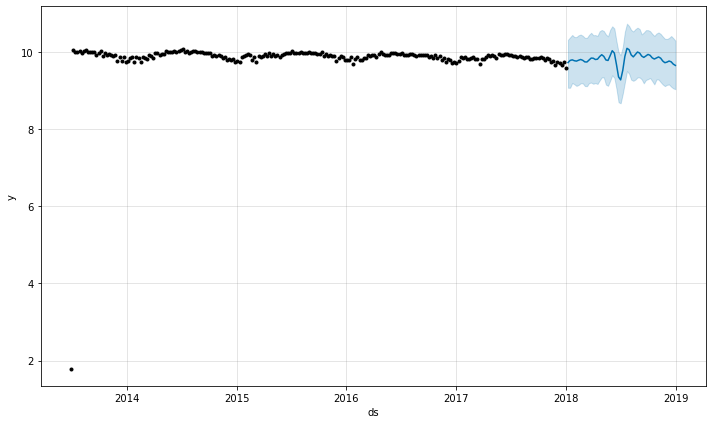

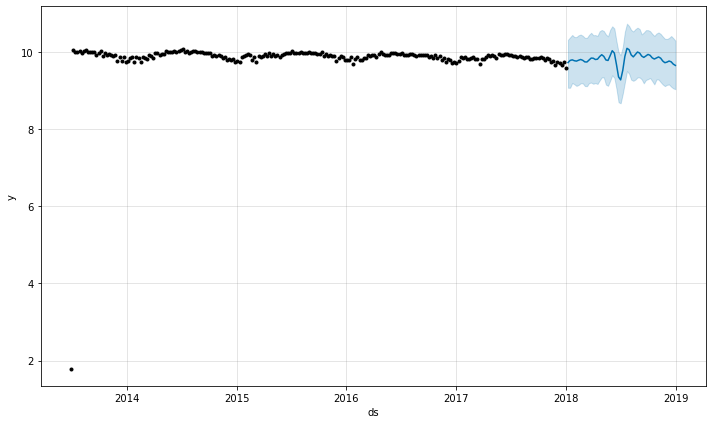

In [416]:
# print(f'r2: {r2_score(future_calls_df.y, future_calls_df.yhat)}')
# print(f'MSE: {mean_squared_error(future_calls_df.y, future_calls_df.yhat)}')
# print(f'MAE: {mean_absolute_error(future_calls_df.y, future_calls_df.yhat)}')

# model_calls.plot(future_calls_df)

### Predicting Future Arrest Counts by Week

In [435]:
# future_arrests_df = model_arrests.predict(test_arrests_df)
# future_arrests_df.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-07,5.608509,5.774722,6.076974,5.608509,5.608509,0.309917,0.309917,0.309917,0.282566,...,0.211924,0.211924,0.211924,-0.184573,-0.184573,-0.184573,0.0,0.0,0.0,5.918426
1,2018-01-14,5.608107,5.902501,6.187614,5.608096,5.608161,0.442693,0.442693,0.442693,0.282566,...,0.211924,0.211924,0.211924,-0.051797,-0.051797,-0.051797,0.0,0.0,0.0,6.050800
2,2018-01-21,5.607705,6.021385,6.310973,5.607425,5.608162,0.561511,0.561511,0.561511,0.282566,...,0.211924,0.211924,0.211924,0.067021,0.067021,0.067021,0.0,0.0,0.0,6.169216
3,2018-01-28,5.607303,6.067210,6.360292,5.606518,5.608278,0.601153,0.601153,0.601153,0.282566,...,0.211924,0.211924,0.211924,0.106663,0.106663,0.106663,0.0,0.0,0.0,6.208455
4,2018-02-04,5.606901,6.022879,6.320350,5.605425,5.608807,0.567238,0.567238,0.567238,0.282566,...,0.211924,0.211924,0.211924,0.072748,0.072748,0.072748,0.0,0.0,0.0,6.174139
5,2018-02-11,5.606499,5.972630,6.263959,5.604002,5.609254,0.519966,0.519966,0.519966,0.282566,...,0.211924,0.211924,0.211924,0.025476,0.025476,0.025476,0.0,0.0,0.0,6.126464
6,2018-02-18,5.606097,5.967068,6.259294,5.602615,5.609661,0.510232,0.510232,0.510232,0.282566,...,0.211924,0.211924,0.211924,0.015742,0.015742,0.015742,0.0,0.0,0.0,6.116328
7,2018-02-25,5.605694,5.998532,6.293252,5.600766,5.610127,0.537841,0.537841,0.537841,0.282566,...,0.211924,0.211924,0.211924,0.043351,0.043351,0.043351,0.0,0.0,0.0,6.143536
8,2018-03-04,5.605292,6.026202,6.332057,5.598948,5.610916,0.567988,0.567988,0.567988,0.282566,...,0.211924,0.211924,0.211924,0.073498,0.073498,0.073498,0.0,0.0,0.0,6.173280
9,2018-03-11,5.604890,6.027753,6.326398,5.597236,5.611689,0.576161,0.576161,0.576161,0.282566,...,0.211924,0.211924,0.211924,0.081672,0.081672,0.081672,0.0,0.0,0.0,6.181052


In [436]:
# future_arrest_df.join(test_arrests_df['y']).reset_index()
# future_arrests_df = future_arrests_df.set_index('ds').join(test_arrests_df.set_index('ds').y).reset_index()
# future_arrests_df.dropna(inplace=True)
# future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-07,5.897154,5.918426,5.774722,6.076974
1,2018-01-14,6.042633,6.050800,5.902501,6.187614
2,2018-01-21,6.251904,6.169216,6.021385,6.310973
3,2018-01-28,6.359574,6.208455,6.067210,6.360292
4,2018-02-04,6.082219,6.174139,6.022879,6.320350


In [437]:
# future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 0 to 51
Data columns (total 5 columns):
ds            52 non-null datetime64[ns]
y             52 non-null float64
yhat          52 non-null float64
yhat_lower    52 non-null float64
yhat_upper    52 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.4 KB


#### Metrics and Plotting Arrests Predictions by Week

r2: -0.16676663531485292
MSE: 0.016160537456653655
MAE: 0.10687312244885169


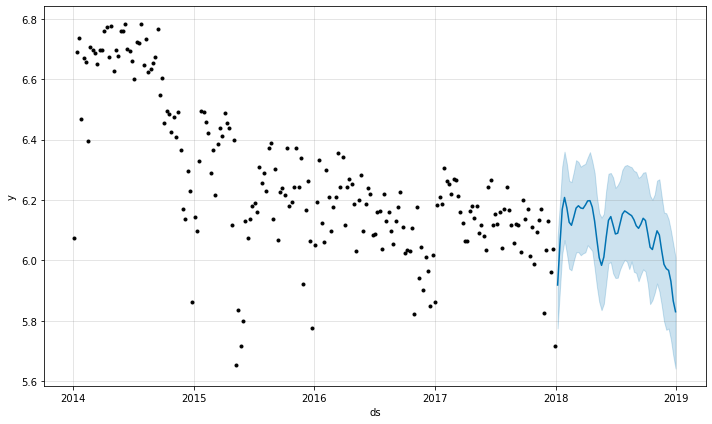

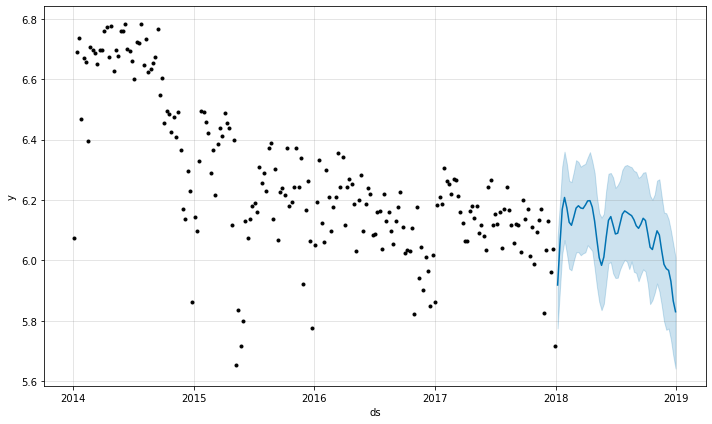

In [438]:
# print(f'r2: {r2_score(future_arrests_df.y, future_arrests_df.yhat)}')
# print(f'MSE: {mean_squared_error(future_arrests_df.y, future_arrests_df.yhat)}')
# print(f'MAE: {mean_absolute_error(future_arrests_df.y, future_arrests_df.yhat)}')

# model_arrests.plot(future_arrests_df)

### Prediciting Future Call Counts by Day

In [369]:
# future_calls_df = model_calls.predict(test_calls_df)
# future_calls_df.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,7.832272,7.478215,7.900523,7.832272,7.832272,-0.151086,-0.151086,-0.151086,-0.007123,-0.007123,-0.007123,-0.143963,-0.143963,-0.143963,0.0,0.0,0.0,7.681186
1,2018-01-02,7.832003,7.500678,7.925889,7.832003,7.832003,-0.125329,-0.125329,-0.125329,0.017152,0.017152,0.017152,-0.142481,-0.142481,-0.142481,0.0,0.0,0.0,7.706674
2,2018-01-03,7.831733,7.499671,7.931543,7.831733,7.831733,-0.120173,-0.120173,-0.120173,0.020173,0.020173,0.020173,-0.140347,-0.140347,-0.140347,0.0,0.0,0.0,7.711560
3,2018-01-04,7.831464,7.506220,7.925567,7.831464,7.831464,-0.117977,-0.117977,-0.117977,0.019613,0.019613,0.019613,-0.137590,-0.137590,-0.137590,0.0,0.0,0.0,7.713487
4,2018-01-05,7.831195,7.539298,7.951209,7.831195,7.831195,-0.081650,-0.081650,-0.081650,0.052603,0.052603,0.052603,-0.134253,-0.134253,-0.134253,0.0,0.0,0.0,7.749545
5,2018-01-06,7.830926,7.501105,7.907747,7.830926,7.830926,-0.125216,-0.125216,-0.125216,0.005171,0.005171,0.005171,-0.130387,-0.130387,-0.130387,0.0,0.0,0.0,7.705709
6,2018-01-07,7.830656,7.384292,7.806307,7.830656,7.830656,-0.233646,-0.233646,-0.233646,-0.107590,-0.107590,-0.107590,-0.126056,-0.126056,-0.126056,0.0,0.0,0.0,7.597010
7,2018-01-08,7.830387,7.494010,7.906679,7.830387,7.830387,-0.128455,-0.128455,-0.128455,-0.007123,-0.007123,-0.007123,-0.121331,-0.121331,-0.121331,0.0,0.0,0.0,7.701933
8,2018-01-09,7.830118,7.504329,7.953456,7.830118,7.830118,-0.099138,-0.099138,-0.099138,0.017152,0.017152,0.017152,-0.116290,-0.116290,-0.116290,0.0,0.0,0.0,7.730980
9,2018-01-10,7.829849,7.526135,7.962879,7.829849,7.829849,-0.090841,-0.090841,-0.090841,0.020173,0.020173,0.020173,-0.111014,-0.111014,-0.111014,0.0,0.0,0.0,7.739008


In [370]:
# future_calls_df.describe()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.0,365.0,365.000000
mean,7.783270,7.569221,8.001401,7.753351,7.818664,0.000080,0.000080,0.000080,-0.000020,-0.000020,-0.000020,0.000099,0.000099,0.000099,0.0,0.0,0.0,7.783349
std,0.028408,0.088188,0.082367,0.051575,0.003910,0.082055,0.082055,0.082055,0.047067,0.047067,0.047067,0.067168,0.067168,0.067168,0.0,0.0,0.0,0.084802
min,7.734268,7.258802,7.708661,7.656737,7.814910,-0.252439,-0.252439,-0.252439,-0.107590,-0.107590,-0.107590,-0.144874,-0.144874,-0.144874,0.0,0.0,0.0,7.482099
25%,7.758769,7.515960,7.951025,7.710022,7.815653,-0.061540,-0.061540,-0.061540,-0.007123,-0.007123,-0.007123,-0.064321,-0.064321,-0.064321,0.0,0.0,0.0,7.735739
50%,7.783270,7.583185,8.015115,7.757747,7.817496,0.012018,0.012018,0.012018,0.017152,0.017152,0.017152,0.023007,0.023007,0.023007,0.0,0.0,0.0,7.795375
75%,7.807771,7.640629,8.067274,7.799320,7.820178,0.066597,0.066597,0.066597,0.020173,0.020173,0.020173,0.049679,0.049679,0.049679,0.0,0.0,0.0,7.852455
max,7.832272,7.730158,8.149385,7.832272,7.832272,0.148243,0.148243,0.148243,0.052603,0.052603,0.052603,0.097988,0.097988,0.097988,0.0,0.0,0.0,7.935630


In [371]:
# future_calls_df.join(test_calls_df['y']).reset_index()
# future_calls_df = future_calls_df.set_index('ds').join(test_calls_df.set_index('ds').y).reset_index()
# future_calls_df.dropna(inplace=True)
# future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01,7.591357,7.681186,7.478215,7.900523
1,2018-01-02,7.760893,7.706674,7.500678,7.925889
2,2018-01-03,7.803843,7.711560,7.499671,7.931543
3,2018-01-04,7.662468,7.713487,7.506220,7.925567
4,2018-01-05,7.835975,7.749545,7.539298,7.951209


In [372]:
# future_calls_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 5 columns):
ds            365 non-null datetime64[ns]
y             365 non-null float64
yhat          365 non-null float64
yhat_lower    365 non-null float64
yhat_upper    365 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 17.1 KB


#### Metrics and Plotting Calls Predictions by Day

r2: -0.2899530616982038
MSE: 0.022694541702190398
MAE: 0.11035102602048169


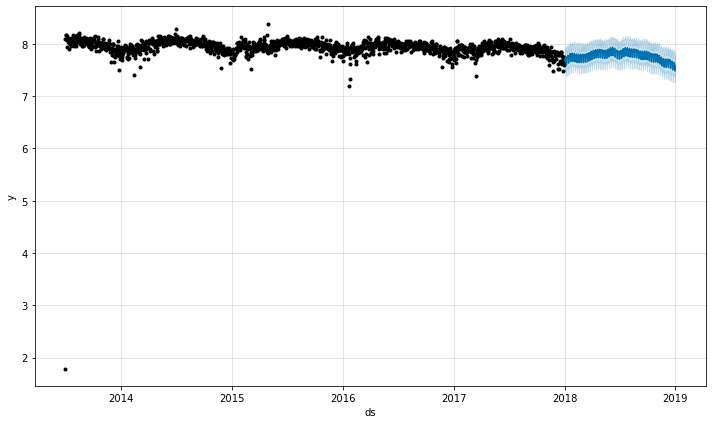

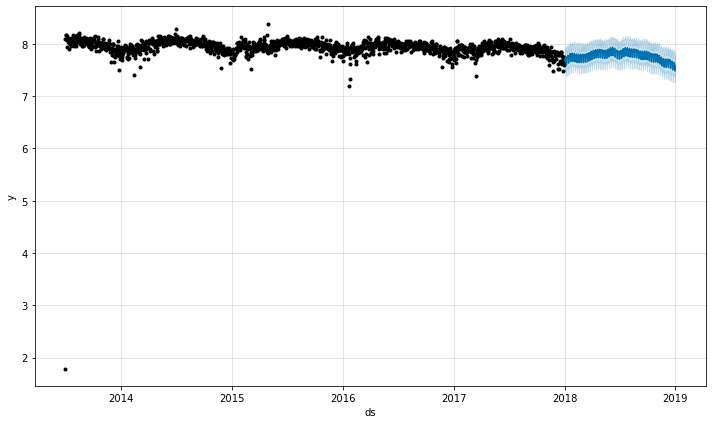

In [373]:
# print(f'r2: {r2_score(future_calls_df.y, future_calls_df.yhat)}')
# print(f'MSE: {mean_squared_error(future_calls_df.y, future_calls_df.yhat)}')
# print(f'MAE: {mean_absolute_error(future_calls_df.y, future_calls_df.yhat)}')

# model_calls.plot(future_calls_df)

### Predicting Future Arrest Counts by Day

In [376]:
# future_arrests_df = model_arrests.predict(test_arrests_df)
# future_arrests_df.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,63.934879,25.580534,66.112327,63.934879,63.934879,-17.405172,-17.405172,-17.405172,-3.554524,-3.554524,-3.554524,-13.850648,-13.850648,-13.850648,0.0,0.0,0.0,46.529707
1,2018-01-02,63.929915,44.307446,83.315984,63.929915,63.929915,-0.887102,-0.887102,-0.887102,12.221639,12.221639,12.221639,-13.108742,-13.108742,-13.108742,0.0,0.0,0.0,63.042813
2,2018-01-03,63.924952,47.991252,87.076772,63.924952,63.924952,3.834583,3.834583,3.834583,16.100466,16.100466,16.100466,-12.265883,-12.265883,-12.265883,0.0,0.0,0.0,67.759535
3,2018-01-04,63.919989,46.015920,86.112279,63.919989,63.919989,2.678017,2.678017,2.678017,14.009588,14.009588,14.009588,-11.331571,-11.331571,-11.331571,0.0,0.0,0.0,66.598006
4,2018-01-05,63.915025,39.519294,77.467052,63.915025,63.915025,-6.642584,-6.642584,-6.642584,3.674561,3.674561,3.674561,-10.317145,-10.317145,-10.317145,0.0,0.0,0.0,57.272441
5,2018-01-06,63.910062,18.556683,57.736912,63.910062,63.910062,-25.169193,-25.169193,-25.169193,-15.933633,-15.933633,-15.933633,-9.235560,-9.235560,-9.235560,0.0,0.0,0.0,38.740869
6,2018-01-07,63.905099,9.885233,49.636282,63.905099,63.905099,-34.619214,-34.619214,-34.619214,-26.518098,-26.518098,-26.518098,-8.101116,-8.101116,-8.101116,0.0,0.0,0.0,29.285884
7,2018-01-08,63.900135,33.883190,72.696207,63.900135,63.900135,-10.483682,-10.483682,-10.483682,-3.554524,-3.554524,-3.554524,-6.929158,-6.929158,-6.929158,0.0,0.0,0.0,53.416454
8,2018-01-09,63.895172,50.829916,90.914992,63.895172,63.895172,6.485882,6.485882,6.485882,12.221639,12.221639,12.221639,-5.735757,-5.735757,-5.735757,0.0,0.0,0.0,70.381054
9,2018-01-10,63.890208,56.013821,95.362795,63.890208,63.890208,11.563098,11.563098,11.563098,16.100466,16.100466,16.100466,-4.537368,-4.537368,-4.537368,0.0,0.0,0.0,75.453307


In [377]:
# future_arrest_df.join(test_arrests_df['y']).reset_index()
# future_arrests_df = future_arrests_df.set_index('ds').join(test_arrests_df.set_index('ds').y).reset_index()
# future_arrests_df.dropna(inplace=True)
# future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01,36,46.529707,25.580534,66.112327
1,2018-01-02,58,63.042813,44.307446,83.315984
2,2018-01-03,74,67.759535,47.991252,87.076772
3,2018-01-04,78,66.598006,46.015920,86.112279
4,2018-01-05,50,57.272441,39.519294,77.467052


In [378]:
# future_arrests_df[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 5 columns):
ds            365 non-null datetime64[ns]
y             365 non-null int64
yhat          365 non-null float64
yhat_lower    365 non-null float64
yhat_upper    365 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 17.1 KB


#### Metrics and Plotting Arrests Predictions by Week

r2: 0.5016345347769486
MSE: 178.50127102115619
MAE: 10.748135413753028


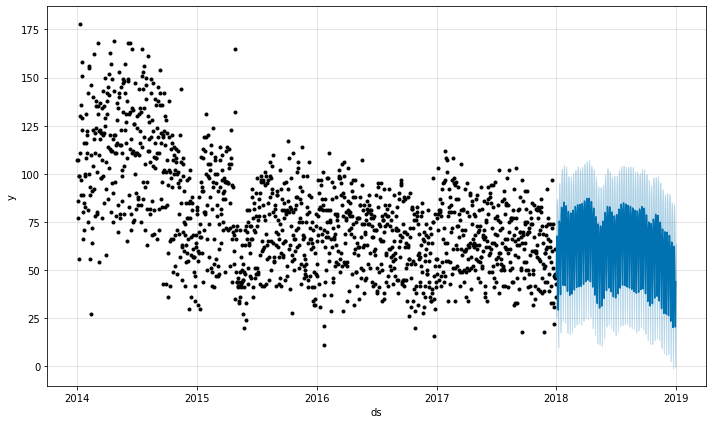

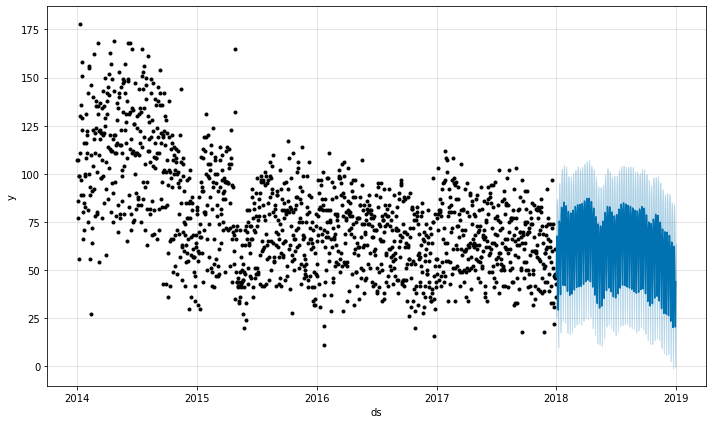

In [379]:
# print(f'r2: {r2_score(future_arrests_df.y, future_arrests_df.yhat)}')
# print(f'MSE: {mean_squared_error(future_arrests_df.y, future_arrests_df.yhat)}')
# print(f'MAE: {mean_absolute_error(future_arrests_df.y, future_arrests_df.yhat)}')

# model_arrests.plot(future_arrests_df)

# Moving window, FB Prophet

In [149]:
#df with test and train, test df, length of train df, len of test df
def moving_window_preds(df, test_df, window_length, test_len):
    preds_df = None
    
    min_idx = 0
    max_idx = window_length - 1
    
    df = df.rename(columns={"count":'y'})
    df["ds"] = df.index
    
    test_df = test_df.rename(columns={"count":'y'})
    test_df["ds"] = test_df.index
    model = Prophet(growth='logistic',)
    for i in range(test_len):
        future_test_df = pd.DataFrame(((model.fit(df[min_idx: max_idx])).predict(test_df)).iloc[i])
        if i == 0:
            preds_df = (future_test_df.transpose()).copy(deep = True)
        else:
            preds_df = preds_df.append(future_test_df.transpose())
        min_idx +=1
        max_idx +=1
    preds_df.set_index('ds').join(test_df.set_index('ds').y).reset_index(drop = True, inplace=True)
    preds_df.dropna(inplace=True)
    return(preds_df)

In [61]:
def print_metrics(df):
    print(f'r2: {r2_score(df.y, df.yhat)}')
    print(f'MSE: {mean_squared_error(df.y, df.yhat)}')
    print(f'MAE: {mean_absolute_error(df.y, df.yhat)}')
    print(f'RMSE: {sqrt(mean_squared_error(df.y, df.yhat))}')

## Monthly, FB Prophet

In [666]:
pred_2018_m = moving_window_preds(time_series_m_df, test_calls_m_df, len(train_calls_m_df), len(test_calls_m_df))


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [835]:
pred_2018_m = pred_2018_m.set_index('ds').join(test_calls_m_df.set_index('ds').y).reset_index()
pred_2018_m.dropna(inplace=True)
pred_2018_m[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

print(f'r2: {r2_score(pred_2018_m.y, pred_2018_m.yhat)}')
print(f'MSE: {mean_squared_error(pred_2018_m.y, pred_2018_m.yhat)}')
print(f'MAE: {mean_absolute_error(pred_2018_m.y, pred_2018_m.yhat)}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_m.y, pred_2018_m.yhat))}')

r2: 0.19766600408578172
MSE: 27386650.359401982
MAE: 3830.0981124875966
RMSE: 5233.2256170933415


,y,ds
CallDateTime,,
2018-01-07,15404,2018-01-07
2018-01-14,17498,2018-01-14
2018-01-21,17267,2018-01-21
2018-01-28,18721,2018-01-28
2018-02-04,16902,2018-02-04
2018-02-11,15540,2018-02-11
2018-02-18,17087,2018-02-18
2018-02-25,17228,2018-02-25
2018-03-04,17508,2018-03-04


In [699]:
pred_2018_arrests_m = moving_window_preds(arrests_date_m_df, test_arrests_m_df, len(train_arrests_m_df), len(test_arrests_m_df))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [700]:
pred_2018_arrests_m = pred_2018_arrests_m.set_index('ds').join(test_arrests_m_df.set_index('ds').y).reset_index()
pred_2018_arrests_m.dropna(inplace=True)
pred_2018_arrests_m[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-31,2094,1798.07,1533.89,2055.86
1,2018-02-28,1762,1677.53,1417.92,1943.57
2,2018-03-31,1885,1978.21,1768.83,2190.21
3,2018-04-30,1774,2038.99,1839.25,2235.29
4,2018-05-31,1799,1575.12,1408.46,1742.11


In [855]:
print(f'r2: {r2_score(pred_2018_arrests_m.y, pred_2018_arrests_m.yhat)}')
print(f'MSE: {mean_squared_error(pred_2018_arrests_m.y, pred_2018_arrests_m.yhat)}')
print(f'MAE: {mean_absolute_error(pred_2018_arrests_m.y, pred_2018_arrests_m.yhat)}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_arrests_m.y, pred_2018_arrests_m.yhat))}')

r2: -0.7418147153600334
MSE: 40429.938730611044
MAE: 175.5402893338485
RMSE: 201.07197400585454


In [ ]:
#by district

In [859]:
pred_2018_SD_m = moving_window_preds(calls_m_SD_df, test_m_SD, len(train_m_SD), len(test_m_SD))
# pred_2018_SD_m = pred_2018_SD_m.set_index('ds').join(test_m_SD.set_index('ds').y).reset_index()
# pred_2018_SD_m.dropna(inplace=True)
# pred_2018_SD_m[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-31,7966,8251.1,7857.06,8668.35
1,2018-02-28,6914,7648.62,7233.11,8009.13
2,2018-03-31,7938,8301.15,7887.61,8673.02
3,2018-04-30,8599,8810.56,8423.52,9150.45
4,2018-05-31,9591,9089.05,8730.92,9438.77


In [860]:
# print_metrics(pred_2018_SD_m)

r2: 0.6532440151928534
MSE: 282356.08524841885
MAE: 420.6633889825642
RMSE: 531.3718897800474


## Weekly, FB Prophet

In [669]:
pred_2018_w = moving_window_preds(time_series_w_df, test_calls_w_df, len(train_calls_w_df), len(test_calls_w_df))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [670]:
pred_2018_w = pred_2018_w.set_index('ds').join(test_calls_w_df.set_index('ds').y).reset_index()
pred_2018_w.dropna(inplace=True)
pred_2018_w[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-07,15404,16069.9,14108.1,18077.2
1,2018-01-14,17498,15927.1,14957.4,16911.9
2,2018-01-21,17267,16590,15576.7,17522.1
3,2018-01-28,18721,17166,16228.8,18202.8
4,2018-02-04,16902,17083.3,16118.1,18099.5


In [836]:
print(f'r2: {r2_score(pred_2018_w.y, pred_2018_w.yhat)}')
print(f'MSE: {mean_squared_error(pred_2018_w.y, pred_2018_w.yhat)}')
print(f'MAE: {mean_absolute_error(pred_2018_w.y, pred_2018_w.yhat)}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_w.y, pred_2018_w.yhat))}')

r2: 0.15603695736198064
MSE: 1361011.5149504247
MAE: 856.0136054587293
RMSE: 1166.6239818169454


In [707]:
sum(pred_2018_w.y)

961636

In [708]:
sum(pred_2018_w.yhat)

930949.8584225089

In [702]:
pred_2018_arrests_w = moving_window_preds(arrests_date_w_df, test_arrests_w_df, len(train_arrests_w_df), len(test_arrests_w_df))


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [703]:
pred_2018_arrests_w = pred_2018_arrests_w.set_index('ds').join(test_arrests_w_df.set_index('ds').y).reset_index()
pred_2018_arrests_w.dropna(inplace=True)
pred_2018_arrests_w[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-07,363,326.3,240.479,410.057
1,2018-01-14,420,400.513,317.445,485.264
2,2018-01-21,518,442.723,366.935,523.529
3,2018-01-28,577,458.099,375.554,535.501
4,2018-02-04,437,463.205,384.834,538.147


In [856]:
print(f'r2: {r2_score(pred_2018_arrests_w.y, pred_2018_arrests_w.yhat)}')
print(f'MSE: {mean_squared_error(pred_2018_arrests_w.y, pred_2018_arrests_w.yhat)}')
print(f'MAE: {mean_absolute_error(pred_2018_arrests_w.y, pred_2018_arrests_w.yhat)}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_arrests_w.y, pred_2018_arrests_w.yhat))}')

r2: -0.04760666032891314
MSE: 2472.71551373646
MAE: 41.7352455226697
RMSE: 49.726406603900706


In [705]:
sum(pred_2018_arrests_w.y)

21599

In [706]:
sum(pred_2018_arrests_w.yhat)

22115.488369151855

In [ ]:
# by district

In [861]:
pred_2018_SD_w = moving_window_preds(calls_w_SD_df, test_w_SD, len(train_w_SD), len(test_w_SD))
pred_2018_SD_w = pred_2018_SD_w.set_index('ds').join(test_w_SD.set_index('ds').y).reset_index()
pred_2018_SD_w.dropna(inplace=True)
pred_2018_SD_w[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-07,1576,1768.52,1629.15,1917.5
1,2018-01-14,1812,1780.17,1626.88,1916.24
2,2018-01-21,1821,1815.2,1665.61,1963.52
3,2018-01-28,1999,1857.15,1716.43,1989.92
4,2018-02-04,1741,1850.99,1690.18,1997.98


In [862]:
print_metrics(pred_2018_SD_w)

r2: 0.5770420839055783
MSE: 18701.546479287215
MAE: 109.5826248469501
RMSE: 136.75359768315866


## Daily, FB Prophet

In [62]:
pred_2018_d = moving_window_preds(time_series_d_df, test_calls_d_df, len(train_calls_d_df), len(test_calls_d_df))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

In [63]:
time_series_d_df.describe()

,count
count,2340.000000
mean,2669.228205
std,740.209605
min,0.000000
25%,2524.750000
50%,2764.500000
75%,2995.000000
max,4694.000000


In [64]:
pred_2018_d = pred_2018_d.set_index('ds').join(test_calls_d_df.set_index('ds').y).reset_index()
pred_2018_d.dropna(inplace=True)
pred_2018_d[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01,1946,2100.47,1853.23,2369.71
1,2018-01-02,2310,2169.37,1940.35,2401.13
2,2018-01-03,2407,2175.4,1941.16,2406.82
3,2018-01-04,2099,2189.47,1954.12,2436.17
4,2018-01-05,2482,2297.36,2062.6,2523.12


In [93]:
print(f'r2: {r2_score(pred_2018_d.y, (pred_2018_d.yhat).astype(int))}')
print(f'MSE: {mean_squared_error(pred_2018_d.y, (pred_2018_d.yhat).astype(int))}')
print(f'MAE: {mean_absolute_error(pred_2018_d.y, (pred_2018_d.yhat).astype(int))}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_d.y, (pred_2018_d.yhat).astype(int)))}')

r2: 0.4633050467252888
MSE: 45636.531506849315
MAE: 151.4191780821918
RMSE: 213.6270851433622


In [710]:
pred_2018_arrests_d = moving_window_preds(arrests_date_d_df, test_arrests_d_df, len(train_arrests_d_df), len(test_arrests_d_df))

pred_2018_arrests_d = pred_2018_arrests_d.set_index('ds').join(test_arrests_d_df.set_index('ds').y).reset_index()
pred_2018_arrests_d.dropna(inplace=True)
pred_2018_arrests_d[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01,36,45.9719,26.7452,67.3322
1,2018-01-02,58,63.2004,43.7378,83.4256
2,2018-01-03,74,67.6731,47.4624,87.1772
3,2018-01-04,78,66.6715,48.8991,88.2609
4,2018-01-05,50,57.6397,38.6989,77.4839


In [857]:
print(f'r2: {r2_score(pred_2018_arrests_d.y, pred_2018_arrests_d.yhat)}')
print(f'MSE: {mean_squared_error(pred_2018_arrests_d.y, pred_2018_arrests_d.yhat)}')
print(f'MAE: {mean_absolute_error(pred_2018_arrests_d.y, pred_2018_arrests_d.yhat)}')
print(f'RMSE: {sqrt(mean_squared_error(pred_2018_arrests_d.y, pred_2018_arrests_d.yhat))}')

r2: 0.5783076625529032
MSE: 151.0389934031637
MAE: 9.809306465292337
RMSE: 12.289792244100942


In [863]:
pred_2018_SD_d = moving_window_preds(calls_d_SD_df, test_d_SD, len(train_d_SD), len(test_d_SD))
pred_2018_SD_d = pred_2018_SD_d.set_index('ds').join(test_d_SD.set_index('ds').y).reset_index()
pred_2018_SD_d.dropna(inplace=True)
pred_2018_SD_d[['ds','y', 'yhat', 'yhat_lower', 'yhat_upper']].head()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=Tru

,ds,y,yhat,yhat_lower,yhat_upper
0,2018-01-01,224,234.49,190.781,279.065
1,2018-01-02,232,240.836,196.164,280.313
2,2018-01-03,219,238.324,195.746,283.975
3,2018-01-04,202,238.01,194.962,278.821
4,2018-01-05,274,254.986,211.031,299.883


In [864]:
print_metrics(pred_2018_SD_d)

r2: 0.31504645393952746
MSE: 1276.1837197638347
MAE: 27.40379614441773
RMSE: 35.72371368942253


# Moving window Baseline, FB Prophet

In [86]:
def baseline_preds(df, test_df, window_length, test_len):
    preds = []
    preds_df = pd.DataFrame()
    
    idx = window_length - 1
    
#     df = df.rename(columns={"count":'y'})
#     df["ds"] = df.index
    
#     test_df = test_df.rename(columns={"count":'y'})
#     test_df["ds"] = test_df.index

    for i in range(test_len):
        preds.append(df['count'].iloc[idx + i])
    #preds.set_index('ds').join(test_df.set_index('ds').y).reset_index()
#     preds_df['y'] = test_df.set_index('ds').y
#     preds_df['yhat']
#     preds.dropna(inplace=True)
#     print_metrics(preds)
    return(preds)

## Monthly Baseline

In [682]:
pred_2018_baseline_m = baseline_preds(time_series_m_df, test_calls_m_df, len(train_calls_m_df), len(test_calls_m_df))


In [833]:
print(f'r2: {r2_score(test_calls_m_df.y, pred_2018_baseline_m)}')
print(f'MSE: {mean_squared_error(test_calls_m_df.y, pred_2018_baseline_m)}')
print(f'MAE: {mean_absolute_error(test_calls_m_df.y, pred_2018_baseline_m)}')
print(f'RMSE: {sqrt(mean_squared_error(test_calls_m_df.y, pred_2018_baseline_m))}')

r2: -0.12309181741092945
MSE: 38335310.583333336
MAE: 5682.916666666667
RMSE: 6191.551548952277


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-31,83636.6,66165.2,96092.8,83636.6,83636.6,-2488.92,-2488.92,-2488.92,-2488.92,-2488.92,-2488.92,0,0,0,81147.7
1,2018-02-28,78029.2,65431.9,70460.7,78016.8,78044.9,-10134.8,-10134.8,-10134.8,-10134.8,-10134.8,-10134.8,0,0,0,67894.4
2,2018-03-31,78068.6,73276.2,78335.7,78054.4,78081.6,-2250.42,-2250.42,-2250.42,-2250.42,-2250.42,-2250.42,0,0,0,75818.2
3,2018-04-30,77438.6,77268.1,81908.8,77425,77452.2,2213.11,2213.11,2213.11,2213.11,2213.11,2213.11,0,0,0,79651.7
4,2018-05-31,76671.7,79536.4,84398.4,76654.2,76687.6,5335.45,5335.45,5335.45,5335.45,5335.45,5335.45,0,0,0,82007.1
5,2018-06-30,76078.9,80029.1,84907.2,76062,76097,6500.02,6500.02,6500.02,6500.02,6500.02,6500.02,0,0,0,82578.9
6,2018-07-31,76924.3,82534.6,87715.4,76908,76939.4,8235.41,8235.41,8235.41,8235.41,8235.41,8235.41,0,0,0,85159.7
7,2018-08-31,76545.7,81053.4,86266.2,76529.5,76561.8,7072.19,7072.19,7072.19,7072.19,7072.19,7072.19,0,0,0,83617.9
8,2018-09-30,76128.7,75961.3,81177.3,76117.9,76140.8,2385.39,2385.39,2385.39,2385.39,2385.39,2385.39,0,0,0,78514.1
9,2018-10-31,76090.2,76005.5,80777.4,76080.5,76099.7,2285.71,2285.71,2285.71,2285.71,2285.71,2285.71,0,0,0,78375.9


In [ ]:
pred_2018_SD_d = baseline_preds(calls_d_SD_df, test_d_SD, len(train_d_SD), len(test_d_SD))

## Weekly Baseline

In [684]:
pred_2018_baseline_w = baseline_preds(time_series_w_df, test_calls_w_df, len(train_calls_w_df), len(test_calls_w_df))

In [832]:
print(f'r2: {r2_score(test_calls_w_df.y, pred_2018_baseline_w)}')
print(f'MSE: {mean_squared_error(test_calls_w_df.y, pred_2018_baseline_w)}')
print(f'MAE: {mean_absolute_error(test_calls_w_df.y, pred_2018_baseline_w)}')
print(f'RMSE: {sqrt(mean_squared_error(test_calls_w_df.y, pred_2018_baseline_w))}')

r2: 0.2971628929098761
MSE: 1133425.6923076923
MAE: 789.0
RMSE: 1064.624672035968


## Daily Baseline

In [87]:
pred_2018_baseline_d = baseline_preds(time_series_d_df, test_calls_d_df, len(train_calls_d_df), len(test_calls_d_df))

In [92]:
print(f'r2: {r2_score(test_calls_d_df.y, pred_2018_baseline_d)}')
print(f'MSE: {mean_squared_error(test_calls_d_df.y, pred_2018_baseline_d)}')
print(f'MAE: {mean_absolute_error(test_calls_d_df.y, pred_2018_baseline_d)}')
print(f'RMSE: {sqrt(mean_squared_error(test_calls_d_df.y, pred_2018_baseline_d))}')

r2: 0.061556155022032266
MSE: 79798.25753424657
MAE: 204.9917808219178
RMSE: 282.4858536887229


[1941,
 1946,
 2310,
 2407,
 2099,
 2482,
 2067,
 1858,
 2415,
 2371,
 2497,
 2581,
 2748,
 2343,
 2220,
 2163,
 2485,
 2166,
 2469,
 2784,
 2614,
 2265,
 2609,
 2770,
 2702,
 2642,
 2593,
 2610,
 2431,
 2404,
 2411,
 2416,
 2522,
 2591,
 2318,
 1911,
 2510,
 2466,
 2018,
 2265,
 2453,
 1334,
 2182,
 2469,
 2421,
 2300,
 2731,
 2670,
 2203,
 2062,
 2309,
 2622,
 2823,
 2456,
 2325,
 2343,
 2106,
 2554,
 2599,
 2621,
 2383,
 2673,
 2350,
 2067,
 2402,
 2143,
 2089,
 2427,
 2451,
 2451,
 2261,
 2295,
 2464,
 2260,
 2485,
 2584,
 2528,
 2337,
 2483,
 2119,
 1702,
 2472,
 2468,
 2459,
 592,
 2389,
 2440,
 2447,
 2858,
 2800,
 2444,
 2111,
 2383,
 2515,
 2681,
 2588,
 2740,
 2508,
 2178,
 2314,
 2589,
 2602,
 2861,
 3006,
 2846,
 2182,
 2422,
 2451,
 2586,
 2597,
 2850,
 2505,
 2471,
 2720,
 2550,
 2618,
 3017,
 2905,
 2711,
 2458,
 2622,
 2943,
 2890,
 3165,
 2989,
 2713,
 2404,
 2810,
 2935,
 2954,
 2869,
 2934,
 2806,
 2218,
 2609,
 2780,
 2645,
 2804,
 2718,
 2550,
 2651,
 2800,
 2900,


In [788]:
pred_2018_baseline_arrests_d = baseline_preds(arrests_date_d_df, test_arrests_d_df, len(train_arrests_d_df), len(test_arrests_d_df))

In [813]:
print(f'r2: {r2_score(test_arrests_d_df.y, pred_2018_baseline_arrests_d)}')
print(f'MSE: {mean_squared_error(test_arrests_d_df.y, pred_2018_baseline_arrests_d)}')
print(f'MAE: {mean_absolute_error(test_arrests_d_df.y, pred_2018_baseline_arrests_d)}')
print(f'RMSE: {sqrt(mean_squared_error(test_arrests_d_df.y, pred_2018_baseline_arrests_d))}')

r2: -0.13108133391967125
MSE: 405.1232876712329
MAE: 16.10958904109589
RMSE: 20.127674671238925


In [790]:
sum(pred_2018_baseline_arrests_d)

21642

In [791]:
sum(pred_2018_arrests_d.y)

21628

In [812]:
pred_2018_arrest()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 20 columns):
ds                            365 non-null datetime64[ns]
trend                         365 non-null object
yhat_lower                    365 non-null object
yhat_upper                    365 non-null object
trend_lower                   365 non-null object
trend_upper                   365 non-null object
additive_terms                365 non-null object
additive_terms_lower          365 non-null object
additive_terms_upper          365 non-null object
weekly                        365 non-null object
weekly_lower                  365 non-null object
weekly_upper                  365 non-null object
yearly                        365 non-null object
yearly_lower                  365 non-null object
yearly_upper                  365 non-null object
multiplicative_terms          365 non-null object
multiplicative_terms_lower    365 non-null object
multiplicative_terms_upper    365 non

In [ ]:
# CrossCorrelation Plots

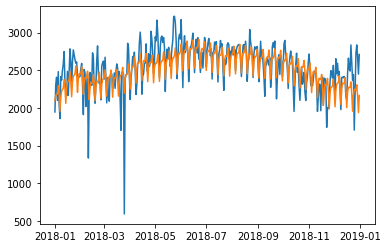

In [162]:
#real and prophet
plt.plot(test_calls_d_df['ds'], test_calls_d_df['y'])
plt.plot(test_calls_d_df['ds'], pred_2018_d.yhat)

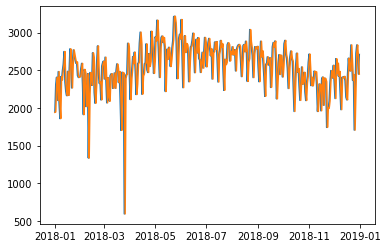

In [161]:
#real and baseline of previous day as current day value
plt.plot(test_calls_d_df['ds'], test_calls_d_df['y'])
plt.plot(test_calls_d_df['ds'],pred_2018_baseline_d)

# SARIMA

In [111]:
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

In [136]:
from pandas.plotting import deregister_matplotlib_converters

deregister_matplotlib_converters()

Test Statistic            -2.295863
p-value                    0.173306
Lags Used                 22.000000
Observations Used       1623.000000
Critical Value (1%)       -3.434386
Critical Value (5%)       -2.863322
Critical Value (10%)      -2.567719
dtype: float64


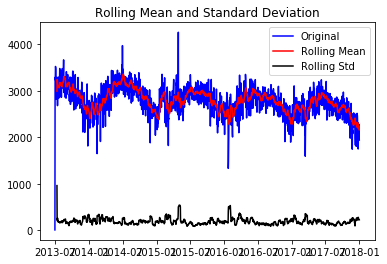

In [112]:
#y = time_series_d_df['count']
y = train_calls_d_df['y']
dftest(y)
#y= np.log(train_calls_d_df['y'])

In [137]:
#
sarima_md = sm.tsa.statespace.SARIMAX(endog = y, order = (1,0,2), seasonal_order = (0,1,1,7),\
                              enforce_stationarity=False, enforce_invertibility = False)
results = sarima_md.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.005    192.107      0.000       0.977       0.997
ma.L1         -0.4896      0.018    -26.688      0.000      -0.526      -0.454
ma.L2         -0.3080      0.021    -14.358      0.000      -0.350      -0.266
ma.S.L7       -0.9749      0.007   -142.711      0.000      -0.988      -0.962
sigma2      2.858e+04    556.562     51.343      0.000    2.75e+04    2.97e+04


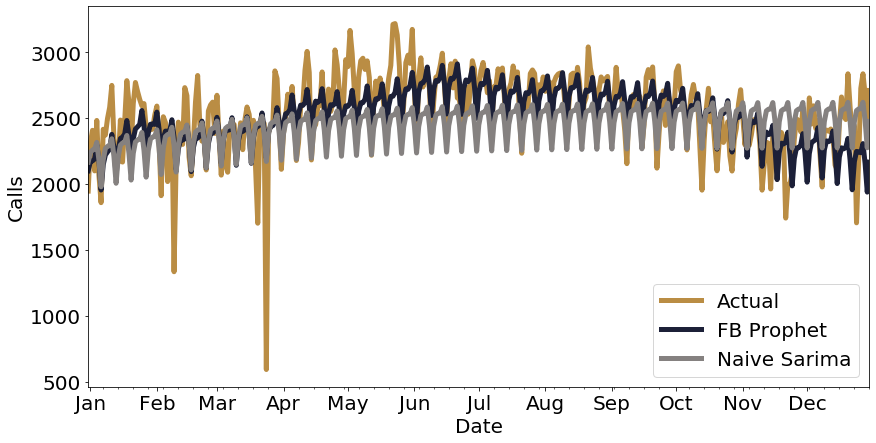

In [206]:
#pred = results.get_prediction(start=pd.to_datetime('2018'), dynamic=False)
pred = results.get_forecast(steps = 365)
pred_ci = pred.conf_int()
ax = test_calls_d_df['y'].plot(label='Actual',color='#BA8D44', linewidth=5) #y['2013':].plot(label='observed') time_series_d_df['count']
(pred_2018_d.yhat).plot(ax=ax, label ='FB Prophet', color='#1C2038', linewidth=5)
(pred.predicted_mean).plot(ax=ax, label='Naive Sarima', figsize=(14, 7), color= '#858180', linewidth=5)

# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date', fontsize= 20)
ax.set_ylabel('Calls', fontsize = 20)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b'))
plt.legend(fontsize= 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("all_three_ts.png", format='png', bbox_inches = 'tight')
plt.show()

## Sarima and FB Prophet Time Series Plotting

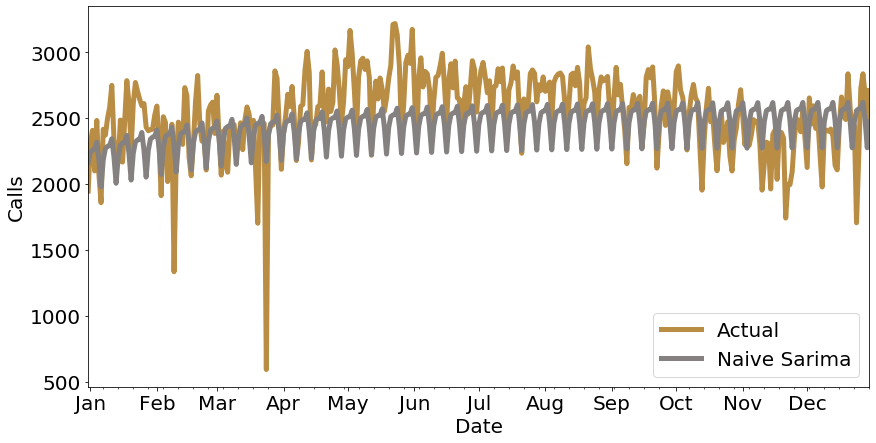

In [207]:
ax = test_calls_d_df['y'].plot(label='Actual',color='#BA8D44', linewidth=5) #y['2013':].plot(label='observed') time_series_d_df['count']
(pred.predicted_mean).plot(ax=ax, label='Naive Sarima', figsize=(14, 7), color= '#858180', linewidth=5)
ax.set_xlabel('Date', fontsize= 20)
ax.set_ylabel('Calls', fontsize = 20)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b'))
plt.legend(fontsize= 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("actual_naive_ts.png", format='png', bbox_inches = 'tight')
plt.show()

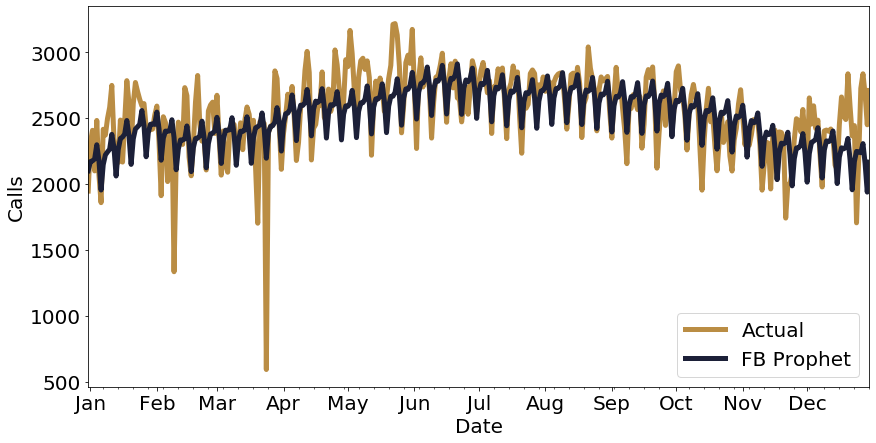

In [208]:
ax = test_calls_d_df['y'].plot(label='Actual',color='#BA8D44', linewidth=5) #y['2013':].plot(label='observed') time_series_d_df['count']
(pred_2018_d.yhat).plot(ax=ax, label ='FB Prophet', color='#1C2038', linewidth=5,  figsize=(14, 7))
ax.set_xlabel('Date', fontsize= 20)
ax.set_ylabel('Calls', fontsize = 20)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%b'))
plt.legend(fontsize= 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("actual_prophet_ts.png", format='png', bbox_inches = 'tight')
plt.show()

In [151]:
pred_2018_d.set_index('ds', inplace=True)
pred_2018_d

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,
2018-01-01,2502.29,1853.23,2369.71,2502.29,2502.29,-401.826,-401.826,-401.826,-36.0375,-36.0375,-36.0375,-365.788,-365.788,-365.788,0,0,0,2100.47,1946
2018-01-02,2500.89,1940.35,2401.13,2500.89,2500.89,-331.524,-331.524,-331.524,28.5557,28.5557,28.5557,-360.079,-360.079,-360.079,0,0,0,2169.37,2310
2018-01-03,2500.28,1941.16,2406.82,2500.28,2500.28,-324.883,-324.883,-324.883,34.1177,34.1177,34.1177,-359.001,-359.001,-359.001,0,0,0,2175.4,2407
2018-01-04,2499.93,1954.12,2436.17,2499.93,2499.93,-310.461,-310.461,-310.461,42.49,42.49,42.49,-352.951,-352.951,-352.951,0,0,0,2189.47,2099
2018-01-05,2502.17,2062.6,2523.12,2502.17,2502.17,-204.81,-204.81,-204.81,138.856,138.856,138.856,-343.666,-343.666,-343.666,0,0,0,2297.36,2482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,2520.7,2022.45,2474.58,2520.7,2520.7,-283.716,-283.716,-283.716,60.6204,60.6204,60.6204,-344.336,-344.336,-344.336,0,0,0,2236.99,2726
2018-12-28,2520.03,2071.33,2539.66,2520.03,2520.03,-213.85,-213.85,-213.85,137.767,137.767,137.767,-351.617,-351.617,-351.617,0,0,0,2306.18,2836
2018-12-29,2524.89,1934.25,2387.88,2524.89,2524.89,-369.466,-369.466,-369.466,-18.5171,-18.5171,-18.5171,-350.949,-350.949,-350.949,0,0,0,2155.43,2680


In [131]:
time_series_d_df['count']

CallDateTime
2013-06-30       6
2013-07-01    3290
2013-07-02    3236
2013-07-03    3525
2013-07-04    3511
              ... 
2019-11-21    3989
2019-11-22    3955
2019-11-23    4410
2019-11-24    3656
2019-11-25    3899
Freq: D, Name: count, Length: 2340, dtype: int64

In [777]:
pred.predicted_mean

2018-01-01    2211.438212
2018-01-02    2287.295135
2018-01-03    2301.754603
2018-01-04    2304.581735
2018-01-05    2353.796504
                 ...     
2018-12-27    2613.495077
2018-12-28    2658.603797
2018-12-29    2509.131619
2018-12-30    2301.288211
2018-12-31    2517.976609
Freq: D, Length: 365, dtype: float64

In [164]:
print(f'r2: {r2_score(test_calls_d_df.y, pred.predicted_mean)}')
print(f'MSE: {mean_squared_error(test_calls_d_df.y, pred.predicted_mean)}')
print(f'MAE: {mean_absolute_error(test_calls_d_df.y, pred.predicted_mean)}')
print(f'RMSE: {sqrt(mean_squared_error(test_calls_d_df.y, pred.predicted_mean))}')

r2: 0.15638379931920043
MSE: 71734.82270915162
MAE: 210.85299090242017
RMSE: 267.833572781964


Test Statistic            -2.096662
p-value                    0.245859
Lags Used                 24.000000
Observations Used       1436.000000
Critical Value (1%)       -3.434912
Critical Value (5%)       -2.863555
Critical Value (10%)      -2.567843
dtype: float64


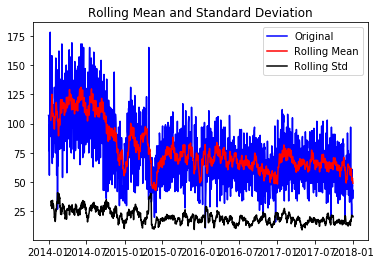

In [798]:
y_arrests = train_arrests_d_df['y']#np.log(train_arrests_d_df['y'] + 1)
dftest(y_arrests)

In [809]:
#
sarima_arrests_md = sm.tsa.statespace.SARIMAX(endog = y, order = (1,0,2), seasonal_order = (0,1,1,7),\
                              enforce_stationarity=False, enforce_invertibility = False)
results_arrests = sarima_md.fit()
print(results_arrests.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.005    190.514      0.000       0.977       0.997
ma.L1         -0.4880      0.019    -26.026      0.000      -0.525      -0.451
ma.L2         -0.3098      0.022    -14.267      0.000      -0.352      -0.267
ma.S.L7       -0.9739      0.007   -148.099      0.000      -0.987      -0.961
sigma2      2.942e+04    583.316     50.431      0.000    2.83e+04    3.06e+04


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



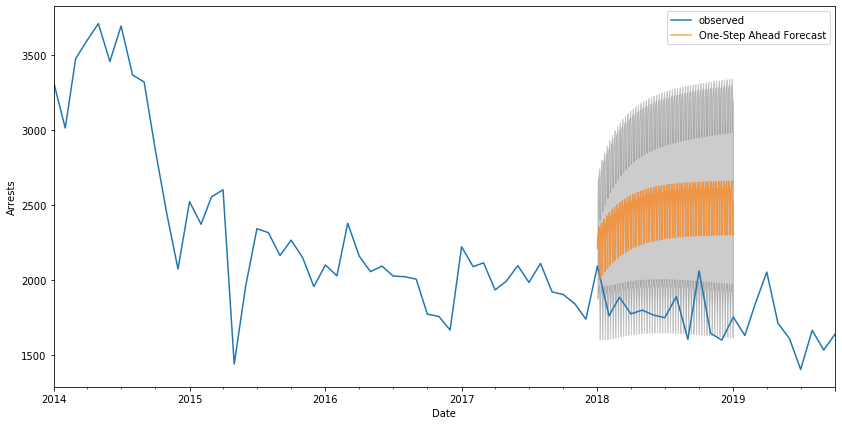

In [810]:
pred_arrests = results.get_forecast(steps = 365)
pred_ci_arrests = pred.conf_int()
ax = arrests_date_df['count'].plot(label='observed') #y['2013':].plot(label='observed')
(pred_arrests.predicted_mean).plot(ax=ax, label='One-Step Ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci_arrests.index,
                pred_ci_arrests.iloc[:, 0],
                pred_ci_arrests.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Arrests')
plt.legend()
plt.show()

In [811]:
print(f'r2: {r2_score(test_arrests_d_df.y, pred_arrests.predicted_mean)}')
print(f'MSE: {mean_squared_error(test_arrests_d_df.y, pred_arrests.predicted_mean)}')
print(f'MAE: {mean_absolute_error(test_arrests_d_df.y, pred_arrests.predicted_mean)}')
print(f'RMSE: {sqrt(mean_absolute_error(test_arrests_d_df.y, pred_arrests.predicted_mean))}')

r2: -16432.8580695832
MSE: 5886171.41014971
MAE: 2422.6636624958555
RMSE: 49.22056137932455
